In [1]:
## cross sections normalised - code from Taimoor Sohail

In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
#JRA_data = xr.open_mfdataset('/g/data/e14/txs156/Data/Observations/JRA/JRA_ACCESS/JRA_ACCESS_fluxes_combi.nc')
from dask.distributed import Client,LocalCluster


In [3]:
client = Client() # n_workers=4
client

<Client: 'tcp://127.0.0.1:32917' processes=7 threads=28, memory=125.19 GiB>

In [4]:
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'


In [5]:
lat_slice = slice(-80, -59)
#start_time, end_time = '2110-01-31', '2159-12-31'
start_time='2150-01-01 00:00:00'
end_time='2159-12-31 00:00:00'

# Import bathymetry - t-grid
ht = cc.querying.getvar(expt, 'ht', session, n=1)
ht = ht.sel(yt_ocean=lat_slice)
# Import bathymetry - u-grid
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)

expt = '01deg_jra55v13_ryf9091_qian_wthmp'
#exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
'''
# Import properties to average
temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, attrs={'cell_methods': 'time: mean'}, frequency='1 monthly')#, ncfile="ocean.nc")
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
salt = salt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
density = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
density = density.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)
'''

'\n# Import properties to average\ntemp = cc.querying.getvar(expt, \'temp\', session, start_time=start_time, end_time=end_time, attrs={\'cell_methods\': \'time: mean\'}, frequency=\'1 monthly\')#, ncfile="ocean.nc")\ntemp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)\nsalt = cc.querying.getvar(expt, \'salt\', session, start_time=start_time, end_time=end_time, frequency=\'1 monthly\')#, ncfile="ocean.nc")\nsalt = salt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)\ndensity = cc.querying.getvar(expt, \'pot_rho_0\', session, start_time=start_time, end_time=end_time, frequency=\'1 monthly\')#, ncfile="ocean.nc")\ndensity = density.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)\nu = cc.querying.getvar(expt, \'u\', session, start_time=start_time, end_time=end_time, frequency=\'1 monthly\')#, ncfile="ocean.nc")\nu = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)\n'

In [6]:
'''
age = cc.querying.getvar(expt, 'age_global', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
age = age.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
'''

'\nage = cc.querying.getvar(expt, \'age_global\', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")\nage = age.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)\n'

In [7]:
%%time
# thickness / area for depth averaging (not time varying):

xt_ocean = cc.querying.getvar(expt,'xt_ocean' , session,n=1)
yt_ocean = cc.querying.getvar(expt,'yt_ocean' , session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_slice)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean}, axis=[1,2])

st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:

area_t = cc.querying.getvar(expt,'area_t',session,n=1)
area_t = area_t.sel(yt_ocean=lat_slice)

volume = area_t*thickness
volume = volume.load()



CPU times: user 21.9 s, sys: 9.84 s, total: 31.8 s
Wall time: 1min 37s


In [8]:
%%time
# thickness / area for depth averaging (not time varying):

xu_ocean = cc.querying.getvar(expt,'xu_ocean' , session,n=1)
yu_ocean = cc.querying.getvar(expt,'yu_ocean' , session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_slice)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':yu_ocean,'xu_ocean':xu_ocean}, axis=[1,2])

st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:

area_u = cc.querying.getvar(expt,'area_u',session,n=1)
area_u = area_u.sel(yu_ocean=lat_slice)

volume_u = area_u*thickness_u
volume_u = volume_u.load()


CPU times: user 14.5 s, sys: 8.83 s, total: 23.4 s
Wall time: 25.1 s


## Do any masking prior to binning with $\textit{xhistogram}$

In [8]:
# We need to define a mask based on the time, longitudes that CSHT is high onto the shelf, vs high off the shelf, AND the 3 regimes identified by the regime mask .

In [84]:
normalised_area_cumsum.values

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.5550846e-04, 2.5541236e-04,
       3.1915313e-04, 4.0245062e-04, 4.9810135e-04, 5.8058981e-04,
       6.5083505e-04, 7.2786742e-04, 8.2804053e-04, 9.0071768e-04,
       1.0368074e-03, 1.1484883e-03, 1.3094475e-03, 1.5103046e-03,
       1.6978212e-03, 1.9118795e-03, 2.1923468e-03, 2.5832625e-03,
       2.9994622e-03, 3.6408287e-03, 4.4505284e-03, 5.4160533e-03,
       6.7509371e-03, 8.3307810e-03, 1.0313757e-02, 1.2893160e-02,
       1.5943404e-02, 2.0024953e-02, 2.6540045e-02, 3.3433154e-02,
       4.5341432e-02, 5.8655228e-02, 7.4776456e-02, 9.0267703e-02,
       1.0308408e-01, 1.1256266e-01, 1.1859578e-01, 1.2275603e-01,
       1.2671363e-01, 1.2920803e-01, 1.3192651e-01, 1.3465834e-01,
       1.3779727e-01, 1.4087179e-01, 1.4448884e-01, 1.4893466e-01,
       1.5477671e-01, 1.6017446e-01, 1.6755545e-01, 1.7824307e-01,
       1.8919624e-01, 2.0537700e-01, 2.2805297e-01, 2.5905710e

In [30]:
import gc
c.run(gc.collect)

{'tcp://10.6.122.59:32975': 538,
 'tcp://10.6.122.59:33047': 512,
 'tcp://10.6.122.59:33341': 605,
 'tcp://10.6.122.59:33837': 937,
 'tcp://10.6.122.59:34053': 803,
 'tcp://10.6.122.59:34225': 803,
 'tcp://10.6.122.59:35483': 995,
 'tcp://10.6.122.59:35717': 980,
 'tcp://10.6.122.59:36449': 666,
 'tcp://10.6.122.59:36537': 826,
 'tcp://10.6.122.59:36937': 639,
 'tcp://10.6.122.59:37045': 611,
 'tcp://10.6.122.59:37239': 511,
 'tcp://10.6.122.59:37447': 1086,
 'tcp://10.6.122.59:37661': 570,
 'tcp://10.6.122.59:38393': 473,
 'tcp://10.6.122.59:38537': 150,
 'tcp://10.6.122.59:39113': 474,
 'tcp://10.6.122.59:39365': 380,
 'tcp://10.6.122.59:39555': 496,
 'tcp://10.6.122.59:39667': 343,
 'tcp://10.6.122.59:41321': 454,
 'tcp://10.6.122.59:41447': 319,
 'tcp://10.6.122.59:41681': 571,
 'tcp://10.6.122.59:42315': 455,
 'tcp://10.6.122.59:42979': 548,
 'tcp://10.6.122.59:44181': 438,
 'tcp://10.6.122.59:45369': 844}

# Load starting from here

In [9]:
%%time
bins_isobath = st_edges_ocean.values
# make histogram of height/depth ht, weighted by values of volume/T/S in xy space, into bins defined by how deep each point is (bins = bins_isobath).

V_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume)
Vu_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u)

A_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = area_t)
#lat-lon area of tracer --- to get the effective area of water column at each isobath depth
Au_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = area_u)
'''
TV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*temp)
SV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*salt)
rhoV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*density)

uV_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u)

T_mean = TV_sum/V_sum
S_mean = SV_sum/V_sum
rho_mean = rhoV_sum/V_sum
u_mean = uV_sum/Vu_sum

T_mean.load()

rho_mean.load()
S_mean.load()
u_mean.load()
'''

CPU times: user 669 ms, sys: 540 ms, total: 1.21 s
Wall time: 1.08 s


"\nTV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*temp)\nSV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*salt)\nrhoV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*density)\n\nuV_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u)\n\nT_mean = TV_sum/V_sum\nS_mean = SV_sum/V_sum\nrho_mean = rhoV_sum/V_sum\nu_mean = uV_sum/Vu_sum\n\nT_mean.load()\n\nrho_mean.load()\nS_mean.load()\nu_mean.load()\n"

In [ ]:

ageV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*age)
age_mean = ageV_sum/V_sum

In [ ]:
age.time

In [ ]:
age_mean.load()

In [189]:
#age_mean.to_netcdf('age_mean_dec0.nc') # year 2110-2120
#age_mean.to_netcdf('age_mean_dec30.nc') # year 2130-2140
age_mean.to_netcdf('age_mean_dec50.nc') # year 2150-2160


In [32]:
rho_mean.load()
S_mean.load()
u_mean.load()

<xarray.DataArray 'histogram_hu' (st_ocean: 75, time: 120, hu_bin: 75)> Size: 5MB
array([[[        nan,         nan,         nan, ...,  0.04332782,
          0.04600806,  0.06650874],
        [        nan,         nan,         nan, ...,  0.04194948,
          0.05278199,  0.04134756],
        [        nan,         nan,         nan, ...,  0.06619285,
          0.07661873,  0.07446453],
        ...,
        [        nan,         nan,         nan, ...,  0.08042327,
          0.08882528,  0.08060593],
        [        nan,         nan,         nan, ...,  0.06849956,
          0.08433243,  0.09853641],
        [        nan,         nan,         nan, ...,  0.0434363 ,
          0.05500471,  0.06728433]],

       [[        nan,         nan,         nan, ...,  0.0324091 ,
          0.03236957,  0.04981074],
        [        nan,         nan,         nan, ...,  0.03424851,
          0.04145448,  0.03309864],
        [        nan,         nan,         nan, ...,  0.05037208,
          0.05821956,  0.05818434],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,  0.00142396],
        [        nan,         nan,         nan, ...,         nan,
                 nan,  0.00218688],
        [        nan,         nan,         nan, ...,         nan,
                 nan,  0.00123096]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * hu_bin   (hu_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

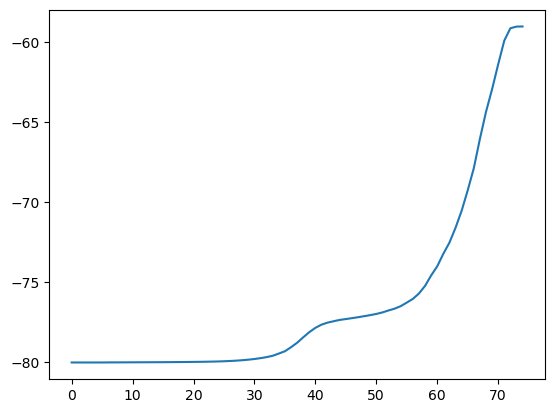

In [26]:
normalised_area_cumsum = A_sum.cumsum('ht_bin')/np.nansum(A_sum)
normalised_area_cumsum_u = Au_sum.cumsum('hu_bin')/np.nansum(Au_sum)

pseudo_lat = -1*(80-(80-59)*normalised_area_cumsum)
plt.plot(pseudo_lat.values)

In [13]:
A_sum

<xarray.DataArray 'histogram_ht' (ht_bin: 75)> Size: 300B
dask.array<sum-aggregate, shape=(75,), dtype=float32, chunksize=(75,), chunktype=numpy.ndarray>
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [14]:
expt

'01deg_jra55v13_ryf9091_qian_wthmp'

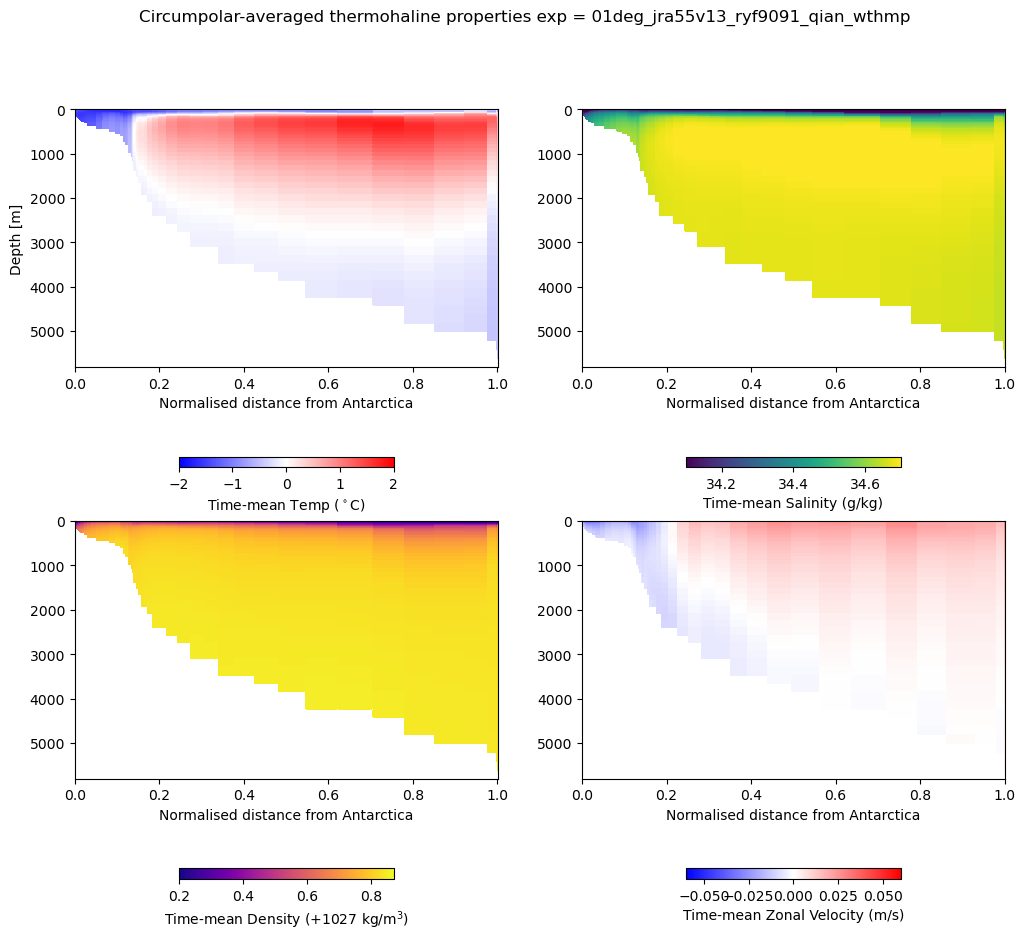

In [25]:
# dec 0
fig, axs = plt.subplots(2,2, figsize=(24*0.5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()


im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, T_mean.mean('time')-273.15, vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, S_mean.mean('time'), vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, rho_mean.mean('time')-1027, vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].pcolor(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

for i in range(4):
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Normalised distance from Antarctica')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.25, orientation = 'horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

plt.suptitle('Circumpolar-averaged thermohaline properties exp = ' + expt)
plt.show()

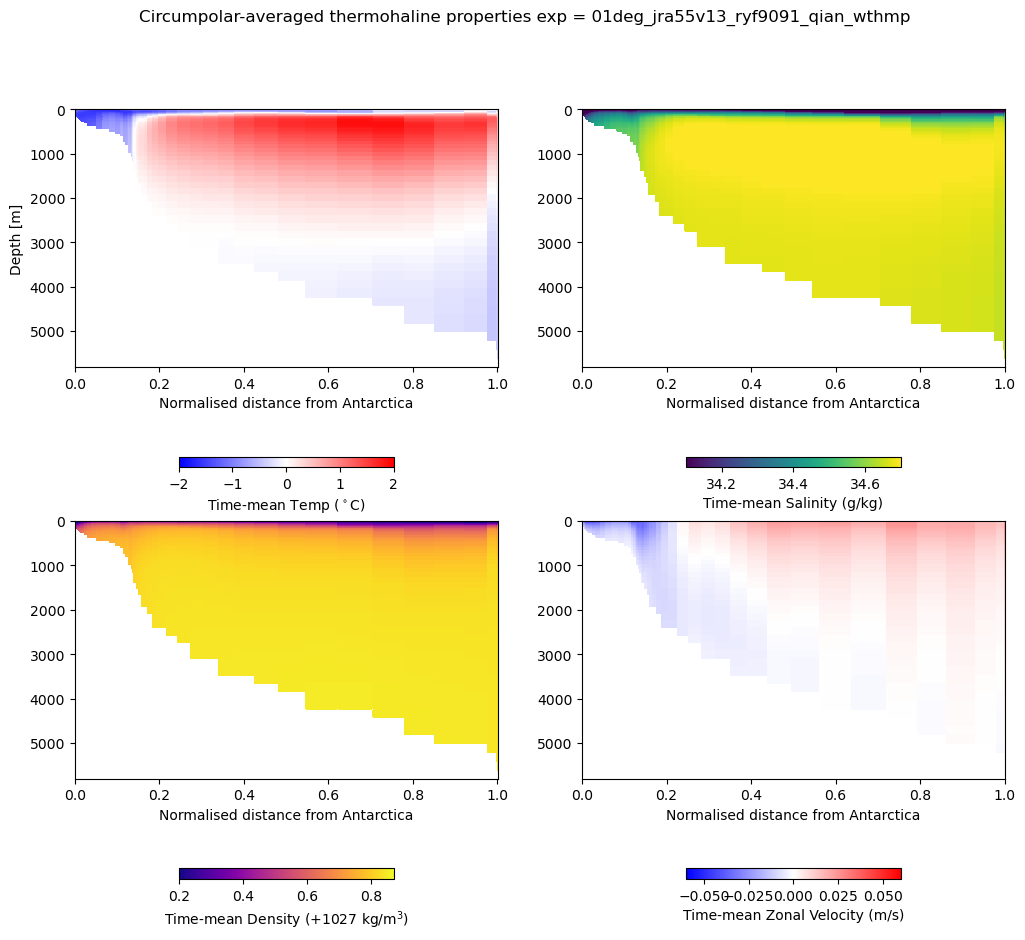

In [35]:
# dec 30
fig, axs = plt.subplots(2,2, figsize=(24*0.5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()


im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, T_mean.mean('time')-273.15, vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, S_mean.mean('time'), vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, rho_mean.mean('time')-1027, vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].pcolor(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

for i in range(4):
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Normalised distance from Antarctica')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.25, orientation = 'horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

plt.suptitle('Circumpolar-averaged thermohaline properties exp = ' + expt)
plt.show()

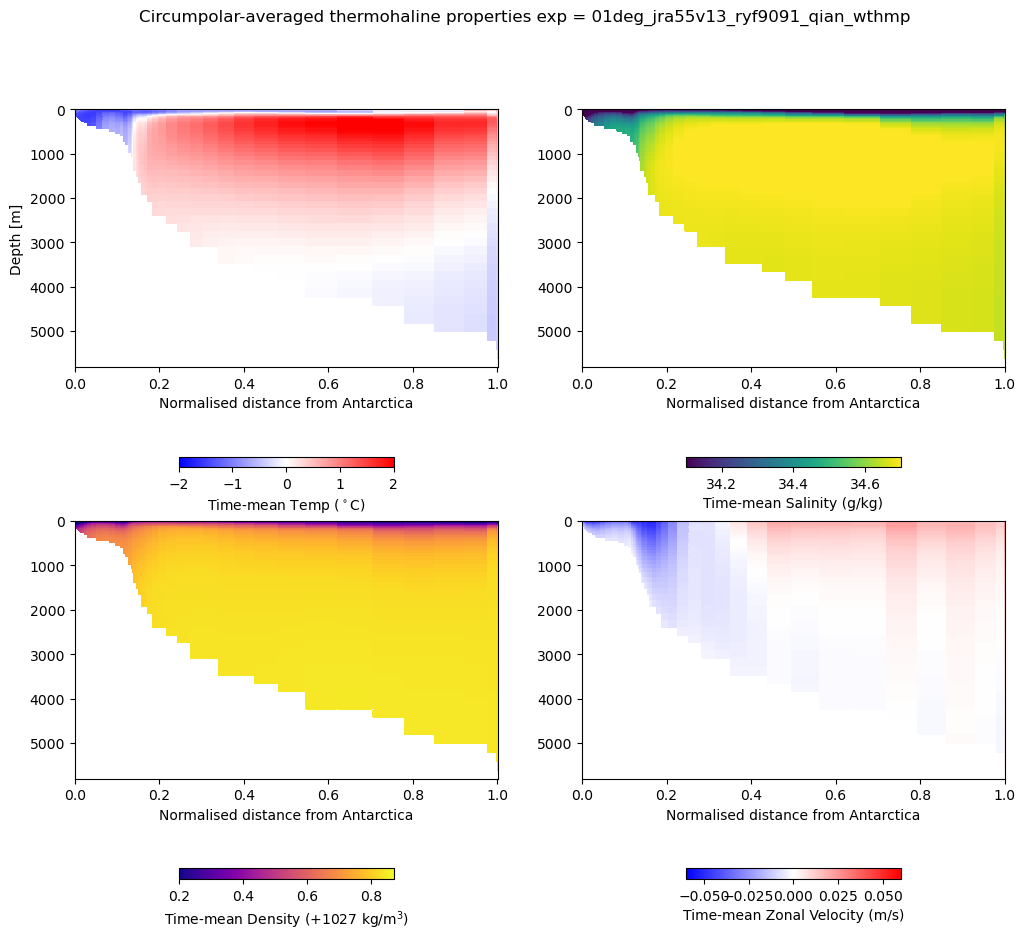

In [15]:
# dec 50
fig, axs = plt.subplots(2,2, figsize=(24*0.5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()


im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, T_mean.mean('time')-273.15, vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, S_mean.mean('time'), vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, rho_mean.mean('time')-1027, vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].pcolor(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

for i in range(4):
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Normalised distance from Antarctica')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.25, orientation = 'horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

plt.suptitle('Circumpolar-averaged thermohaline properties exp = ' + expt)
plt.show()

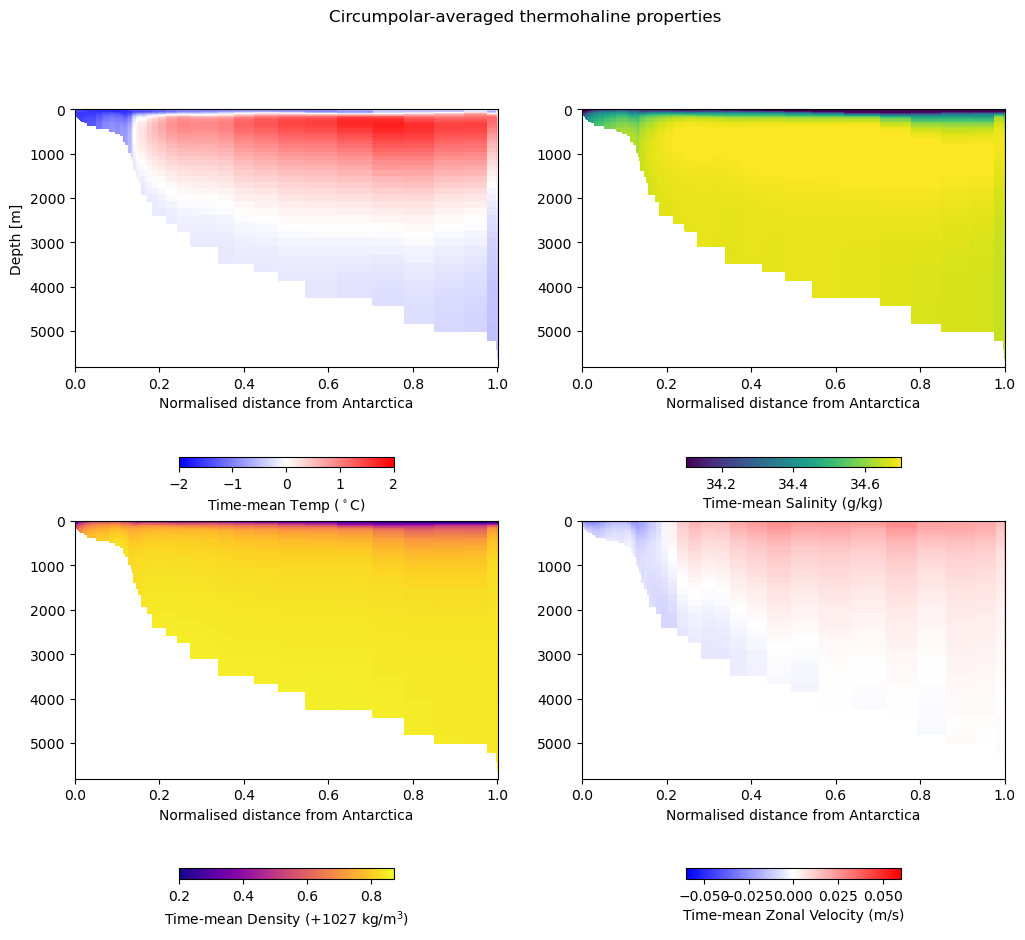

In [16]:
fig, axs = plt.subplots(2,2, figsize=(24*0.5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()


im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, T_mean.mean('time')-273.15, vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, S_mean.mean('time'), vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, rho_mean.mean('time')-1027, vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].pcolor(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

for i in range(4):
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Normalised distance from Antarctica')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.25, orientation = 'horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

plt.suptitle('Circumpolar-averaged thermohaline properties')
plt.show()

In [36]:
'''
T_mean.to_netcdf('T_mean_dec50.nc') # year 2150-2159
S_mean.to_netcdf('S_mean_dec50.nc')
rho_mean.to_netcdf('rho_mean_dec50.nc')
u_mean.to_netcdf('u_mean_dec50.nc')
'''
T_mean.to_netcdf('T_mean_dec30.nc') # year 2130-2140
S_mean.to_netcdf('S_mean_dec30.nc')
rho_mean.to_netcdf('rho_mean_dec30.nc')
u_mean.to_netcdf('u_mean_dec30.nc')
'''
T_mean.to_netcdf('T_mean_dec0.nc') # year 2110-2120
S_mean.to_netcdf('S_mean_dec0.nc')
rho_mean.to_netcdf('rho_mean_dec0.nc')
u_mean.to_netcdf('u_mean_dec0.nc')
'''

"\nT_mean.to_netcdf('T_mean_dec0.nc') # year 2110-2120\nS_mean.to_netcdf('S_mean_dec0.nc')\nrho_mean.to_netcdf('rho_mean_dec0.nc')\nu_mean.to_netcdf('u_mean_dec0.nc')\n"

In [43]:
T_mean.ht_bin

<xarray.DataArray 'ht_bin' (ht_bin: 75)> Size: 600B
array([5.412808e-01, 1.680735e+00, 2.939953e+00, 4.331521e+00, 5.869350e+00,
       7.568810e+00, 9.446885e+00, 1.152234e+01, 1.381593e+01, 1.635055e+01,
       1.915154e+01, 2.224687e+01, 2.566746e+01, 2.944746e+01, 3.362460e+01,
       3.824057e+01, 4.334140e+01, 4.897796e+01, 5.520640e+01, 6.208874e+01,
       6.969342e+01, 7.809601e+01, 8.737988e+01, 9.763700e+01, 1.089687e+02,
       1.214869e+02, 1.353144e+02, 1.505868e+02, 1.674530e+02, 1.860765e+02,
       2.066365e+02, 2.293296e+02, 2.543701e+02, 2.819920e+02, 3.124492e+02,
       3.460166e+02, 3.829906e+02, 4.236883e+02, 4.684475e+02, 5.176242e+02,
       5.715899e+02, 6.307275e+02, 6.954248e+02, 7.660668e+02, 8.430255e+02,
       9.266482e+02, 1.017244e+03, 1.115068e+03, 1.220309e+03, 1.333076e+03,
       1.453384e+03, 1.581154e+03, 1.716205e+03, 1.858264e+03, 2.006975e+03,
       2.161913e+03, 2.322601e+03, 2.488533e+03, 2.659189e+03, 2.834054e+03,
       3.012631e+03, 3.194453e+03, 3.379089e+03, 3.566145e+03, 3.755274e+03,
       3.946166e+03, 4.138551e+03, 4.332197e+03, 4.526903e+03, 4.722497e+03,
       4.918835e+03, 5.115794e+03, 5.313270e+03, 5.511177e+03, 5.709443e+03])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

# Plotting all times with importing

In [12]:
cd /g/data/v45/qo9901/MW-perturb-ASC-data

/g/data/v45/qo9901/MW-perturb-ASC-data


In [13]:
age_mean_50 = xr.open_mfdataset('age_mean_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
age_mean_30 = xr.open_mfdataset('age_mean_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
age_mean_0 = xr.open_mfdataset('age_mean_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )


In [14]:
T_mean_50 = xr.open_mfdataset('T_mean_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) ) # year 2150-2159
S_mean_50 = xr.open_mfdataset('S_mean_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_50 = xr.open_mfdataset('rho_mean_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
u_mean_50 = xr.open_mfdataset('u_mean_dec50.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )

T_mean_30 = xr.open_mfdataset('T_mean_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) ) # year 2130-2140
S_mean_30 = xr.open_mfdataset('S_mean_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_30 = xr.open_mfdataset('rho_mean_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
u_mean_30 = xr.open_mfdataset('u_mean_dec30.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )

T_mean_0 = xr.open_mfdataset('T_mean_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) ) # year 2110-2120
S_mean_0 = xr.open_mfdataset('S_mean_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_0 = xr.open_mfdataset('rho_mean_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
u_mean_0 = xr.open_mfdataset('u_mean_dec0.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )


In [15]:
T_mean_50.mean('time') # ht_bin is lat

<xarray.Dataset> Size: 29kB
Dimensions:       (ht_bin: 60, st_ocean: 60)
Coordinates:
  * ht_bin        (ht_bin) float64 480B 0.5413 1.681 ... 2.659e+03 2.834e+03
Dimensions without coordinates: st_ocean
Data variables:
    histogram_ht  (st_ocean, ht_bin) float64 29kB dask.array<chunksize=(60, 60), meta=np.ndarray>

In [16]:
def fmt(x):
    s = f"{x:.2f}"
    #if s.endswith("0"):
    #    s = f"{x:.0f}"
    return rf"{s} \m/s" if plt.rcParams["text.usetex"] else f"{s} m/s"
'''
def fmt_rho(x):
    s = f"{x:.2f}"
    #if s.endswith("0"):
    #    s = f"{x:.0f}"
    return rf"{s} kg/m$^{3}$" if plt.rcParams["text.usetex"] else f"{s} kg/m$^{3}$"
'''
def fmt_rho(x):
    s = f"{x:.2f}"
    #if s.endswith("0"):
    #    s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s} "


In [17]:
from matplotlib import rc
rc('font', **{'size':35})
rc('text', usetex=False)
rc('xtick', labelsize=35) #20 
rc('ytick', labelsize=35) #20
rc('axes', titlesize=35)    # fontsize of the axes title
rc('axes', labelsize=35) #24    # fontsize of the x and y labels

In [18]:
def plot_topography_isobath(bins_isobath, ax):
    # Example topography and distance arrays
    '''
    topography = generate_cross_section_depth(hu_region.drop(['geolon_c', 'geolat_c']),\
                                               shelf_coord, depth_coord) # Replace with actual topography data
    topography = topography.to_dataframe().set_index(['distance']).to_xarray().hu
    
    distance = u_section.distance  # Replace with actual distance data
    '''
    ax.plot(normalised_area_cumsum, bins_isobath[:60],color = 'g',lw = 4)
                            
    # Specified depth
    specified_depth = 600  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='g', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
    # Specified depth
    specified_depth = 200  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='gray', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
    
    # Specified depth
    specified_depth = 1000  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='gray', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
      # Specified depth
    specified_depth = 2500  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='g', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
    return

In [19]:
normalised_area_cumsum = A_sum.sel(ht_bin = slice(0,3000)).cumsum('ht_bin')/np.nansum(A_sum.sel(ht_bin = slice(0,3000)))
normalised_area_cumsum_u = Au_sum.sel(hu_bin = slice(0,3000)).cumsum('hu_bin')/np.nansum(Au_sum.sel(hu_bin = slice(0,3000)))


In [20]:
st_ocean = st_ocean.sel(st_ocean = slice(0,3000))

In [21]:
st_ocean

<xarray.DataArray 'st_ocean' (st_ocean: 60)> Size: 480B
array([5.412808e-01, 1.680735e+00, 2.939953e+00, 4.331521e+00, 5.869350e+00,
       7.568810e+00, 9.446885e+00, 1.152234e+01, 1.381593e+01, 1.635055e+01,
       1.915154e+01, 2.224687e+01, 2.566746e+01, 2.944746e+01, 3.362460e+01,
       3.824057e+01, 4.334140e+01, 4.897796e+01, 5.520640e+01, 6.208874e+01,
       6.969342e+01, 7.809601e+01, 8.737988e+01, 9.763700e+01, 1.089687e+02,
       1.214869e+02, 1.353144e+02, 1.505868e+02, 1.674530e+02, 1.860765e+02,
       2.066365e+02, 2.293296e+02, 2.543701e+02, 2.819920e+02, 3.124492e+02,
       3.460166e+02, 3.829906e+02, 4.236883e+02, 4.684475e+02, 5.176242e+02,
       5.715899e+02, 6.307275e+02, 6.954248e+02, 7.660668e+02, 8.430255e+02,
       9.266482e+02, 1.017244e+03, 1.115068e+03, 1.220309e+03, 1.333076e+03,
       1.453384e+03, 1.581154e+03, 1.716205e+03, 1.858264e+03, 2.006975e+03,
       2.161913e+03, 2.322601e+03, 2.488533e+03, 2.659189e+03, 2.834054e+03])
Coordinates:
  * st_ocean  (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean
    ncfiles:         ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg...

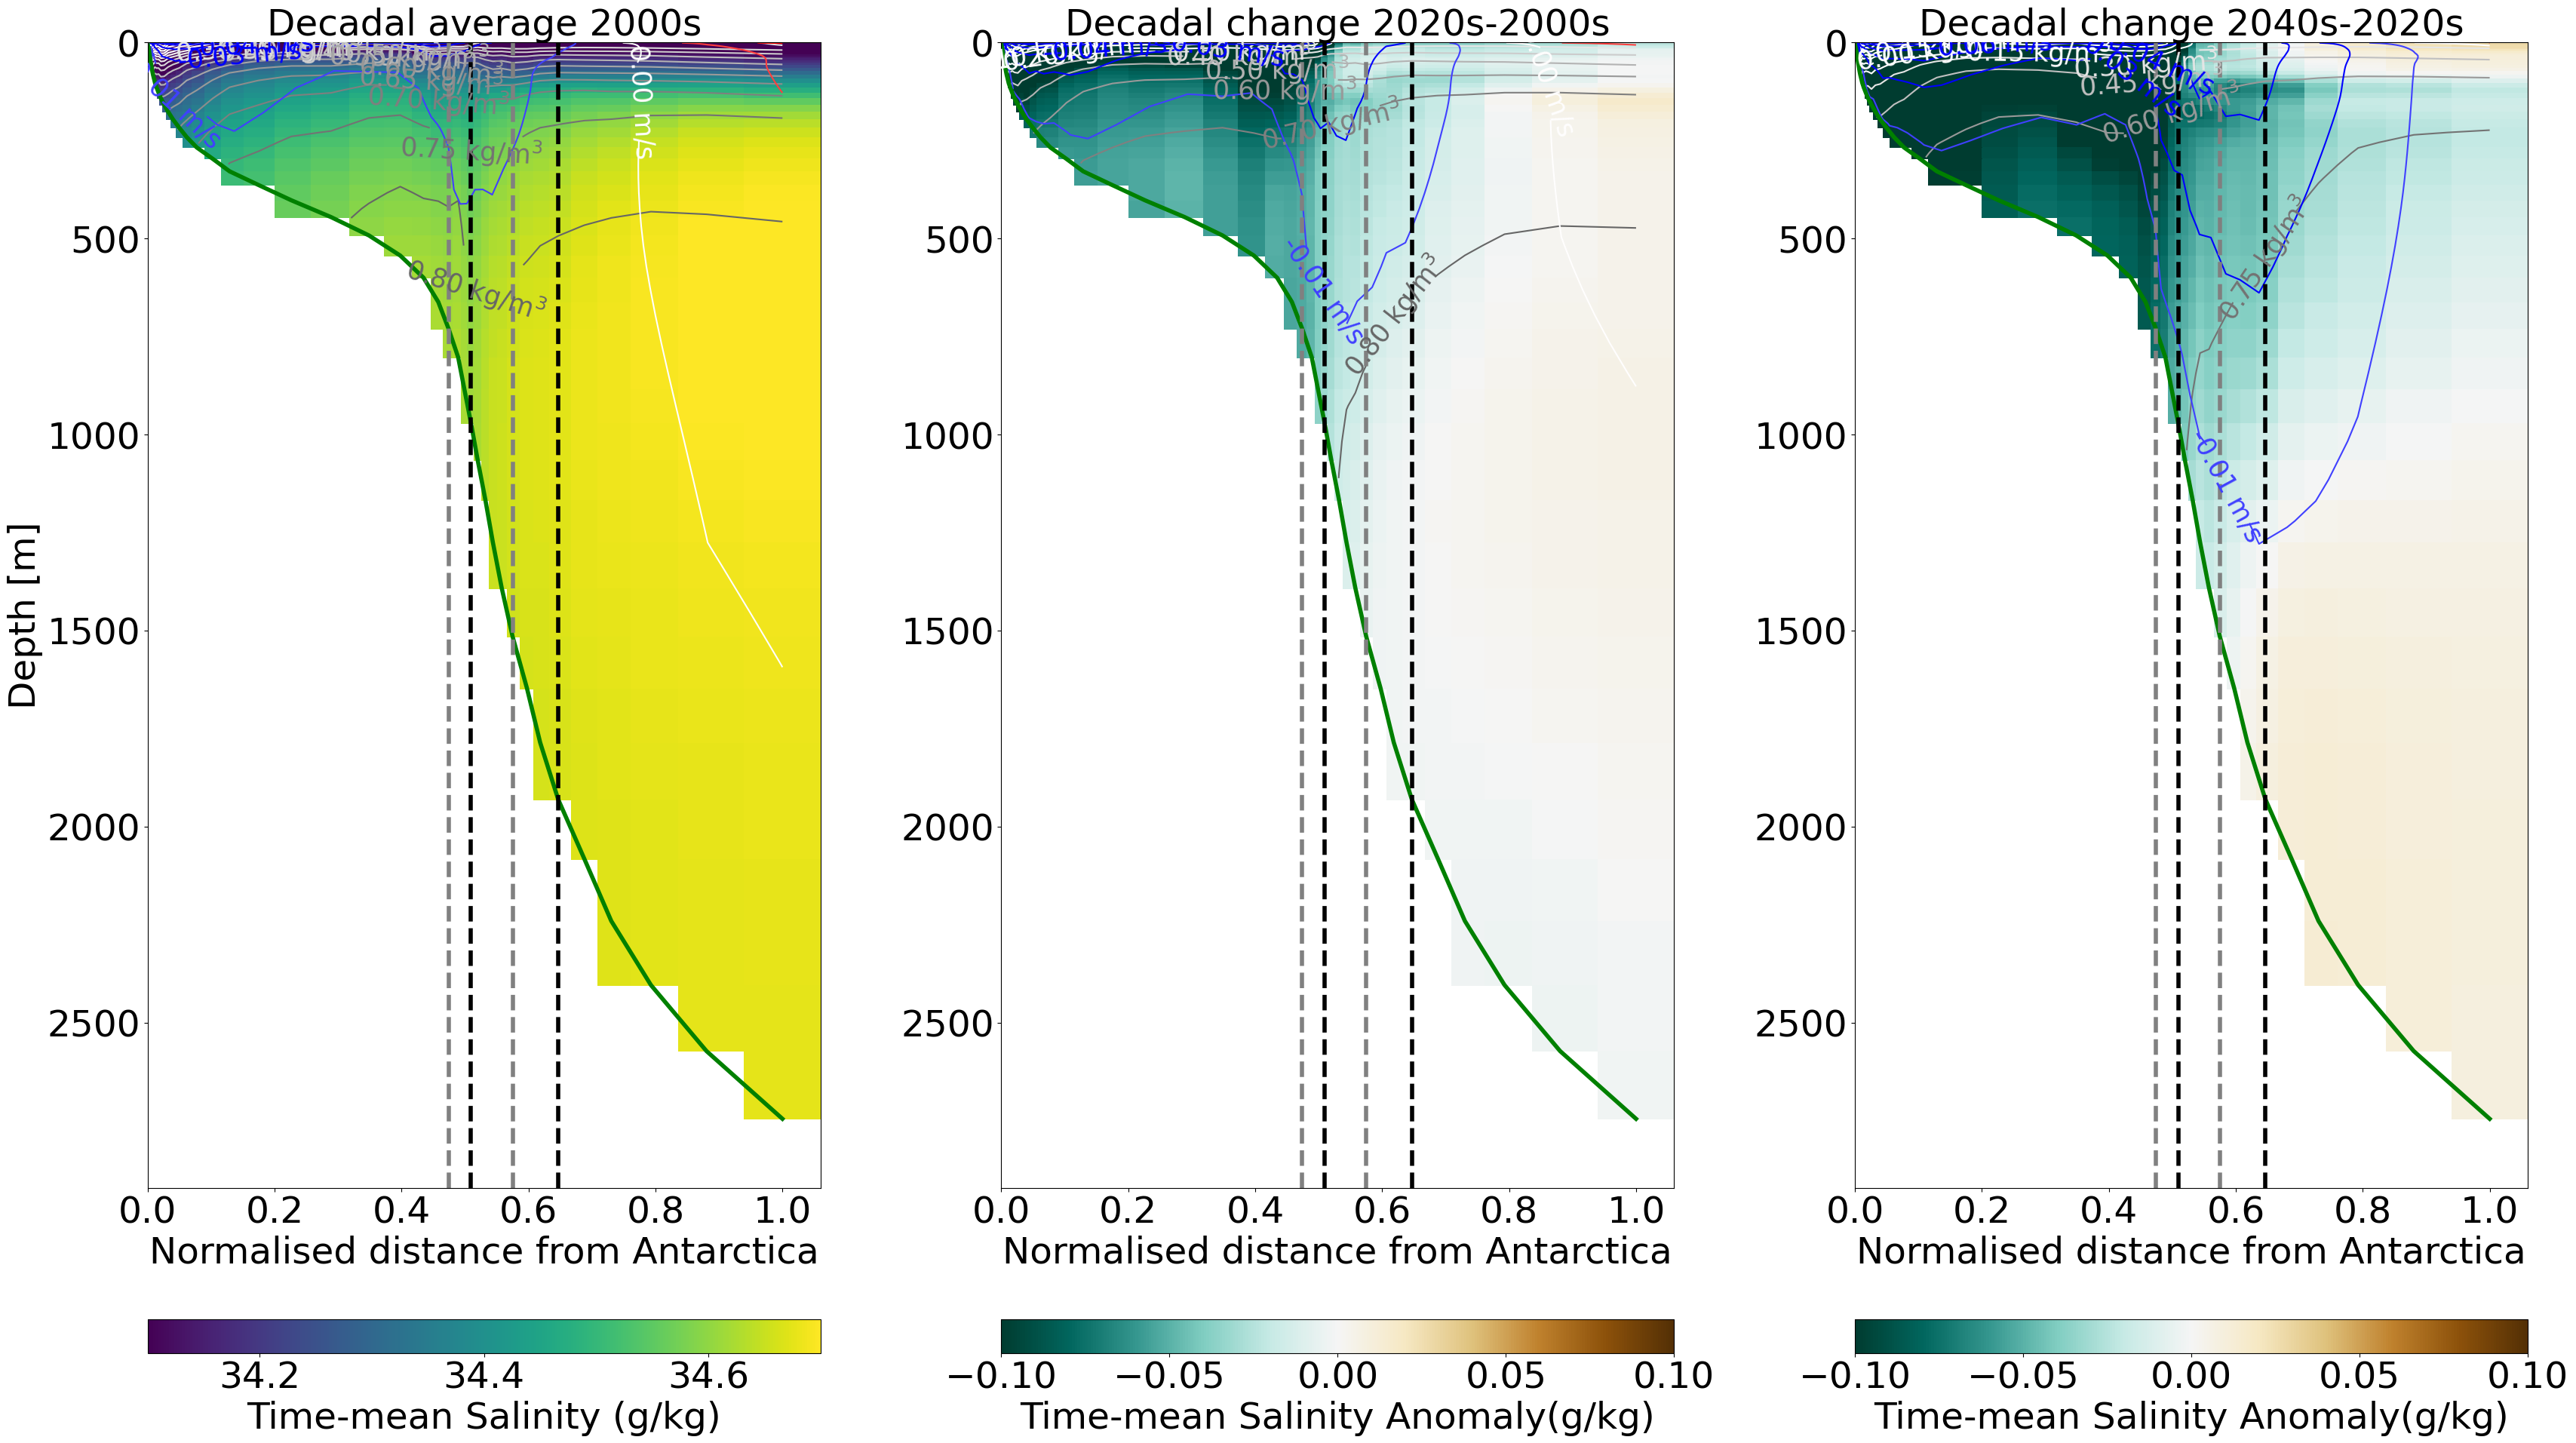

In [21]:
fig, axs = plt.subplots(ncols = 3, figsize=(35,20), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()

im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, S_mean_0.mean('time').histogram_ht.values, vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
cb2 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Time-mean Salinity (g/kg)')


im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, S_mean_30.mean('time').histogram_ht.values - S_mean_0.mean('time').histogram_ht.values, vmin=-0.1, vmax = 0.1, cmap=plt.cm.BrBG_r)
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Time-mean Salinity Anomaly(g/kg)')

im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, S_mean_50.mean('time').histogram_ht.values - S_mean_30.mean('time').histogram_ht.values, vmin=-0.1, vmax = 0.1, cmap=plt.cm.BrBG_r)
cb2 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Time-mean Salinity Anomaly(g/kg)')

vmin_rho = 0.2
vmax_rho = 1.2
vmin_u = -0.02
vmax_u = 0.02
fontsize = 25

CS = axs[0].contour(normalised_area_cumsum, st_ocean, rho_mean_0.mean('time').histogram_ht.values-1027, 20, vmin=vmin_rho, vmax=vmax_rho, cmap=plt.cm.gray_r)
kwargs = {'inline_spacing' : -30, 'inline': True, 'use_clabeltext' : True, 'fontsize':fontsize}
axs[0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)
CS = axs[0].contour(normalised_area_cumsum_u, st_ocean, u_mean_0.mean('time').histogram_hu.values, 10, vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr)
axs[0].clabel(CS, CS.levels, fmt= fmt, **kwargs)

CS = axs[1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  20,vmin=vmin_rho, vmax=vmax_rho, cmap=plt.cm.gray_r)
axs[1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
CS = axs[1].contour(normalised_area_cumsum_u, st_ocean, u_mean_30.mean('time').histogram_hu.values,  10,vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr)
axs[1].clabel(CS, CS.levels, fmt =fmt, **kwargs)

CS = axs[2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027, 20, vmin=vmin_rho, vmax=vmax_rho, cmap=plt.cm.gray_r)
axs[2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
CS = axs[2].contour(normalised_area_cumsum_u, st_ocean, u_mean_50.mean('time').histogram_hu.values, 10, vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr)
axs[2].clabel(CS, CS.levels,  fmt =fmt, **kwargs)

for i in range(3):
    axs[i].set_xlabel('Normalised distance from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[i])

    #axs[i].set_xlim([0,0.3])
axs[0].set_ylabel('Depth [m]')
axs[0].set_title('Decadal average 2000s')
axs[1].set_title('Decadal change 2020s-2000s')
axs[2].set_title('Decadal change 2040s-2020s')
plt.tight_layout()

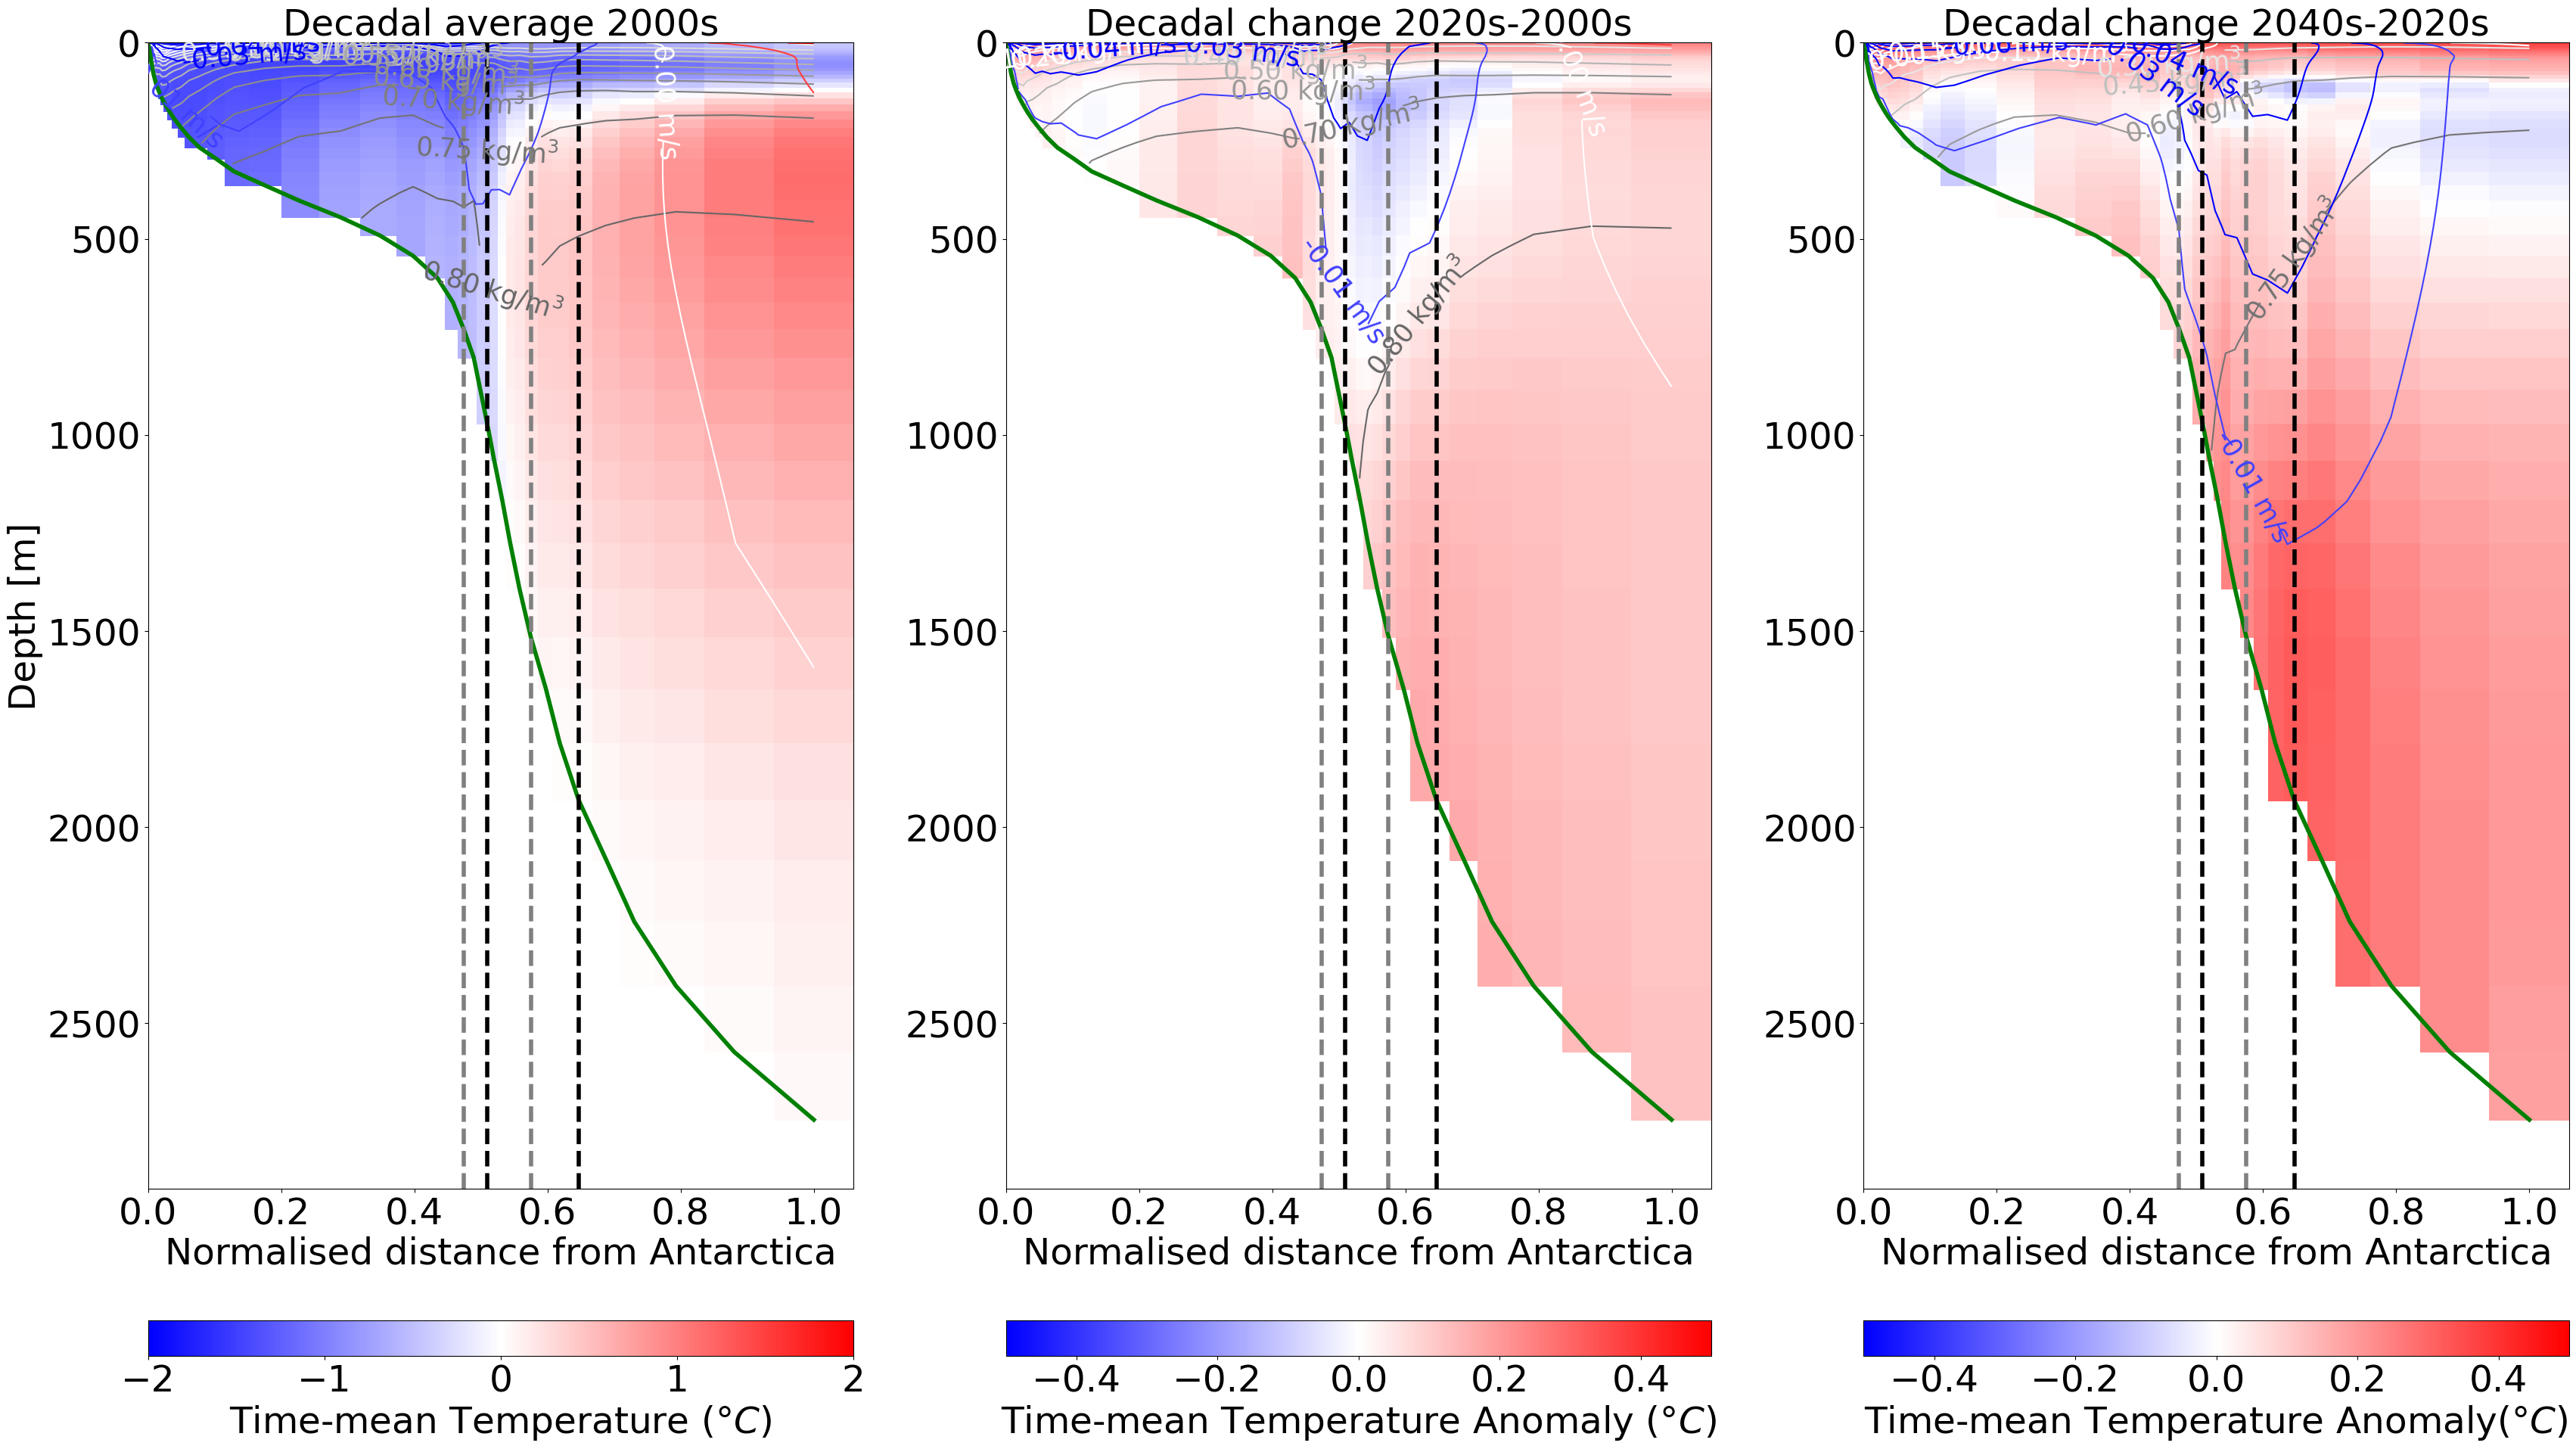

In [22]:
fig, axs = plt.subplots(ncols = 3, figsize=(35,20), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()

im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, T_mean_0.mean('time').histogram_ht.values - 273, vmin=-2, vmax = 2, cmap=plt.cm.bwr)
cb2 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Time-mean Temperature ($\degree C$)')


im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, T_mean_30.mean('time').histogram_ht.values - T_mean_0.mean('time').histogram_ht.values, vmin=-0.5, vmax = 0.5, cmap=plt.cm.bwr)
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Time-mean Temperature Anomaly ($\degree C$)')

im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, T_mean_50.mean('time').histogram_ht.values - T_mean_30.mean('time').histogram_ht.values, vmin=-0.5, vmax =0.5, cmap=plt.cm.bwr)
cb2 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Time-mean Temperature Anomaly($\degree C$)')

vmin_rho = 0.2
vmax_rho = 1.2
vmin_u = -0.02
vmax_u = 0.02
fontsize = 25

CS = axs[0].contour(normalised_area_cumsum, st_ocean, rho_mean_0.mean('time').histogram_ht.values-1027, 20, vmin=vmin_rho, vmax=vmax_rho, cmap=plt.cm.gray_r)
kwargs = {'inline_spacing' : -30, 'inline': True, 'use_clabeltext' : True, 'fontsize':fontsize}
axs[0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)
CS = axs[0].contour(normalised_area_cumsum_u, st_ocean, u_mean_0.mean('time').histogram_hu.values, 10, vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr)
axs[0].clabel(CS, CS.levels, fmt= fmt, **kwargs)

CS = axs[1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  20,vmin=vmin_rho, vmax=vmax_rho, cmap=plt.cm.gray_r)
axs[1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
CS = axs[1].contour(normalised_area_cumsum_u, st_ocean, u_mean_30.mean('time').histogram_hu.values,  10,vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr)
axs[1].clabel(CS, CS.levels, fmt =fmt, **kwargs)

CS = axs[2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027, 20, vmin=vmin_rho, vmax=vmax_rho, cmap=plt.cm.gray_r)
axs[2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
CS = axs[2].contour(normalised_area_cumsum_u, st_ocean, u_mean_50.mean('time').histogram_hu.values, 10, vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr)
axs[2].clabel(CS, CS.levels,  fmt =fmt, **kwargs)

for i in range(3):
    axs[i].set_xlabel('Normalised distance from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[i])

    #axs[i].set_xlim([0,0.3])
axs[0].set_ylabel('Depth [m]')
axs[0].set_title('Decadal average 2000s')
axs[1].set_title('Decadal change 2020s-2000s')
axs[2].set_title('Decadal change 2040s-2020s')
plt.tight_layout()

## getting control age - skip

In [18]:
expt = '01deg_jra55v13_ryf9091'
start_time='2110-01-01 00:00:00'
end_time='2119-12-31 00:00:00'

age = cc.querying.getvar(expt, 'age_global', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
age = age.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

ageV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*age)
age_mean = ageV_sum/V_sum
#age_mean.load()


u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)

uV_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u)
u_mean = uV_sum/Vu_sum
#u_mean.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [19]:
volume.load()

<xarray.DataArray (yt_ocean: 483, xt_ocean: 3600, st_ocean: 75)> Size: 1GB
array([[[              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        ...,
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan]],

       [[              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
...
        [35331710.0736632 , 39045319.22676219, 43149222.03132311, ...,
                0.        ,        0.        ,        0.        ],
        [35331710.0736632 , 39045319.22676219, 43149222.03132311, ...,
                0.        ,        0.        ,        0.        ],
        [35331710.0736632 , 39045319.22676219, 43149222.03132311, ...,
                0.        ,        0.        ,        0.        ]],

       [[35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ],
        [35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ],
        [35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ],
        ...,
        [35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ],
        [35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ],
        [35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ]]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
    geolon_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... 79.75 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... -59.03 -59.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [23]:
'''
temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time , attrs={'cell_methods': 'time: mean'}, frequency='1 monthly')#, ncfile="ocean.nc")
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
TV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*temp)
T_mean = TV_sum/V_sum
'''
salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time , frequency='1 monthly')#, ncfile="ocean.nc")
SV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*salt)
S_mean = SV_sum/V_sum

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [35]:
salt

<xarray.DataArray 'salt' (time: 123, st_ocean: 75, yt_ocean: 2700,
                          xt_ocean: 3600)> Size: 359GB
dask.array<concatenate, shape=(123, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 984B 2109-10-16 12:00:00 ... 2119-12-16 12:00:00
Attributes: (12/13)
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [25]:
V_sum.load()

<xarray.DataArray 'histogram_ht' (st_ocean: 75, ht_bin: 75)> Size: 45kB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.02757032e+11, 1.21208277e+11, 8.43952823e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.97643092e+11, 1.33948112e+11, 9.32658151e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.10250151e+12, 1.48026881e+11, 1.03068625e+10],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.95398939e+13, 2.21366477e+13, 1.54133751e+12],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.15238881e+12, 1.54438807e+12],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.63482317e+12, 6.39568553e+11]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean

In [26]:
S_mean.load()
S_mean.to_netcdf('S_mean_ctrldec0.nc')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

In [28]:
temp.isel(time = 0)#.load()

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 483, xt_ocean: 3600)> Size: 522MB
dask.array<getitem, shape=(75, 483, 3600), dtype=float32, chunksize=(7, 273, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      object 8B 2110-01-16 12:00:00
Attributes: (12/13)
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [32]:
T_mean.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

<xarray.DataArray 'histogram_ht' (st_ocean: 75, time: 120, ht_bin: 75)> Size: 5MB
array([[[         nan,          nan,          nan, ..., 274.92281669,
         275.07642464, 274.69115806],
        [         nan,          nan,          nan, ..., 275.13905281,
         275.26065797, 274.94211853],
        [         nan,          nan,          nan, ..., 274.82361726,
         275.0210632 , 274.66549417],
        ...,
        [         nan,          nan,          nan, ..., 271.85966718,
         272.18658623, 271.98831208],
        [         nan,          nan,          nan, ..., 272.25672919,
         272.65787701, 272.29898404],
        [         nan,          nan,          nan, ..., 273.35379386,
         273.71878189, 273.3579603 ]],

       [[         nan,          nan,          nan, ..., 274.91784772,
         275.0716691 , 274.68841562],
        [         nan,          nan,          nan, ..., 275.13711542,
         275.2592755 , 274.94116578],
        [         nan,          nan,          nan, ..., 274.82529966,
         275.02277437, 274.66732504],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan, 272.73158744],
        [         nan,          nan,          nan, ...,          nan,
                  nan, 272.7310609 ],
        [         nan,          nan,          nan, ...,          nan,
                  nan, 272.73117631]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

In [ ]:
#T_mean.load()
#T_mean.to_netcdf('T_mean_ctrldec0.nc')

In [33]:
T_mean.to_netcdf('T_mean_ctrldec0.nc')

In [23]:
density = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
density = density.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
rhoV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*density)
rho_mean = rhoV_sum/V_sum

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3

In [24]:
rho_mean.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

<xarray.DataArray 'histogram_ht' (st_ocean: 75, time: 117, ht_bin: 75)> Size: 5MB
array([[[          nan,           nan,           nan, ...,
         1026.87990917, 1026.91895924, 1026.76383723],
        [          nan,           nan,           nan, ...,
         1026.91133831, 1026.92505199, 1026.78499576],
        [          nan,           nan,           nan, ...,
         1026.97650371, 1026.97278522, 1026.86673084],
        ...,
        [          nan,           nan,           nan, ...,
         1027.09271806, 1027.074725  , 1026.98831915],
        [          nan,           nan,           nan, ...,
         1027.16930301, 1027.14647509, 1027.07706708],
        [          nan,           nan,           nan, ...,
         1027.24403734, 1027.21614026, 1027.17388713]],

       [[          nan,           nan,           nan, ...,
         1026.88060711, 1026.9197387 , 1026.76474219],
        [          nan,           nan,           nan, ...,
         1026.91158845, 1026.92531185, 1026.78524782],
        [          nan,           nan,           nan, ...,
         1026.97647255, 1026.9727806 , 1026.86671282],
...
        [          nan,           nan,           nan, ...,
                   nan,           nan, 1027.84061082],
        [          nan,           nan,           nan, ...,
                   nan,           nan, 1027.84064206],
        [          nan,           nan,           nan, ...,
                   nan,           nan, 1027.84071185]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

Exception ignored in: <function CachingFileManager.__del__ at 0x146e48156200>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2627, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2590, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2034, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


In [25]:
rho_mean.to_netcdf('rho0_mean_ctrldec0.nc')

In [29]:
#u_mean.to_netcdf('u_mean_ctrldec0.nc') # year 2110-2120


In [22]:
u_mean_ctrl_0 = xr.open_mfdataset('u_mean_ctrldec0.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_ctrl_0 = xr.open_mfdataset('rho0_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
S_mean_ctrl_0 = xr.open_mfdataset('S_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
T_mean_ctrl_0 = xr.open_mfdataset('T_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )


In [23]:
#age_mean.to_netcdf('age_mean_ctrldec0.nc') # year 2110-2120
#age_mean.to_netcdf('age_mean_ctrldec30.nc') # year 2130-2140
#age_mean.to_netcdf('age_mean_ctrldec50.nc') # year 2150-2160


In [24]:
age_mean_ctrl_50 = xr.open_mfdataset('age_mean_ctrldec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
age_mean_ctrl_30 = xr.open_mfdataset('age_mean_ctrldec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
age_mean_ctrl_0 = xr.open_mfdataset('age_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )


In [25]:
age_diff_0 = (age_mean_0.mean('time').histogram_ht.values - age_mean_ctrl_0.mean('time').histogram_ht.values)
age_diff_30 = (age_mean_30.mean('time').histogram_ht.values - age_mean_ctrl_30.mean('time').histogram_ht.values)
age_diff_50 = (age_mean_50.mean('time').histogram_ht.values - age_mean_ctrl_50.mean('time').histogram_ht.values)

# Final plots

In [26]:
import cmocean

In [27]:

vmin_rho = 0.7
vmax_rho = 0.9
levels_rho = np.linspace(vmin_rho, vmax_rho,5)
levels_rho

array([0.7 , 0.75, 0.8 , 0.85, 0.9 ])

[0.7 0.8 0.9]
[0.7 0.8 0.9]
[0.7 0.8 0.9]
[0.7 0.8 0.9]
[0.7 0.8 0.9]


Text(0.07, 2700, '(i)')

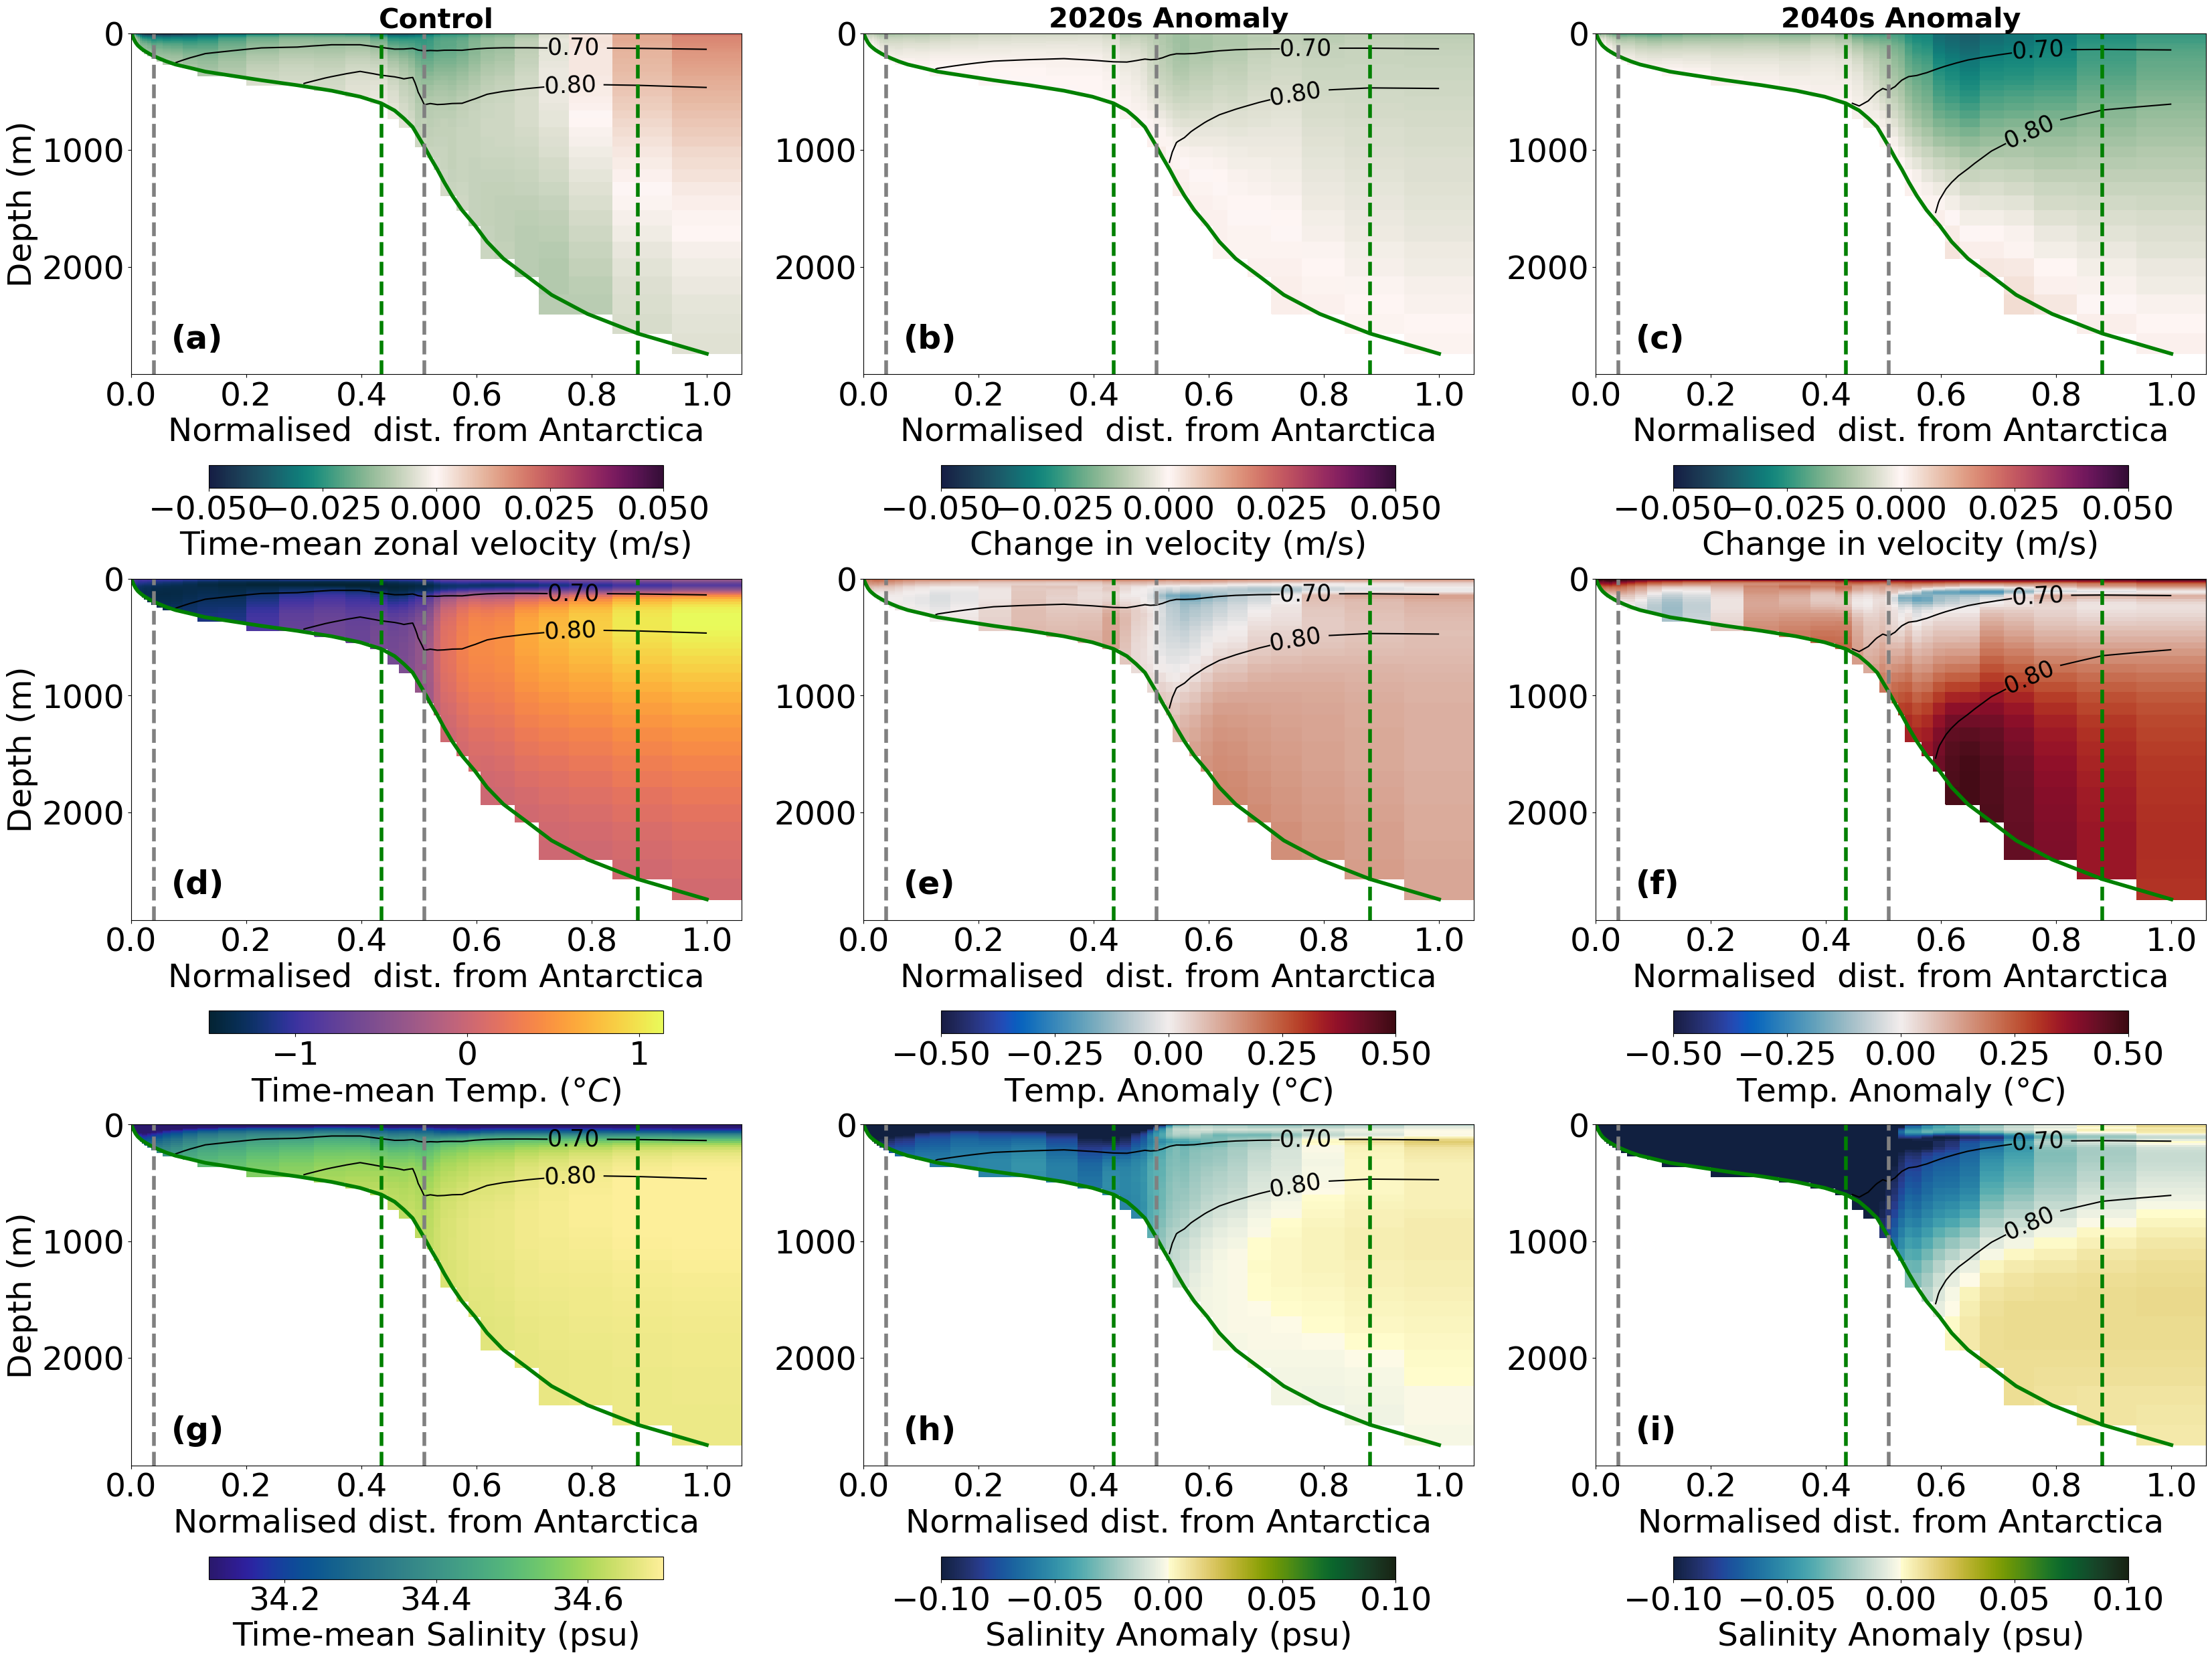

In [29]:
fig, axs = plt.subplots(ncols = 3,nrows = 3, figsize=(40,30), facecolor='w', edgecolor='k')

#########

vmin_rho = 0.7
vmax_rho = 0.9
vmin_u = -0.05
vmax_u = 0.05
fontsize = 25
lw = 5
levels_rho = np.linspace(vmin_rho, vmax_rho,3)
levels_u = np.linspace(vmin_u, vmax_u,11)
manual_locations = [(0.775,200) ,(0.775,1000)]
color_clabel = 'k'

########## ZONAL VELOCITY

im1 = axs[0,0].pcolor(normalised_area_cumsum, st_ocean, u_mean_ctrl_0.mean('time').histogram_hu.values , vmin = vmin_u, vmax = vmax_u, cmap=cmocean.cm.curl)
cb2 = plt.colorbar(im1, ax=axs[0,0], fraction=0.05, pad=0.2,  orientation = 'horizontal')
cb2.set_label('Time-mean zonal velocity (m/s)')


im2 = axs[0,1].pcolor(normalised_area_cumsum, st_ocean, (u_mean_30.mean('time').histogram_hu.values - u_mean_0.mean('time').histogram_hu.values), \
                    vmin = vmin_u, vmax = vmax_u, cmap=cmocean.cm.curl)
cb2 = plt.colorbar(im2, ax=axs[0,1], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Change in velocity (m/s)')

im3 = axs[0,2].pcolor(normalised_area_cumsum, st_ocean, (u_mean_50.mean('time').histogram_hu.values - u_mean_0.mean('time').histogram_hu.values),  \
                    vmin = vmin_u, vmax = vmax_u, cmap=cmocean.cm.curl)
cb2 = plt.colorbar(im3, ax=axs[0,2], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Change in velocity (m/s)')


CS = axs[0,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors =color_clabel)
kwargs = {'inline_spacing' : 0, 'inline': True, 'use_clabeltext' : True, 'fontsize':fontsize, 'manual' : manual_locations}#, 'fontweight':'bold'}
axs[0,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[0,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[0,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)

CS = axs[0,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[0,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

axs[0,0].set_title('Control', fontweight = 'bold',fontsize = 30)
axs[0,1].set_title('2020s Anomaly', fontweight = 'bold',fontsize = 30)
axs[0,2].set_title('2040s Anomaly', fontweight = 'bold',fontsize = 30)

for i in range(3):
    axs[0,i].set_xlabel('Normalised  dist. from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[0,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[0,i])

####### temp

im1 = axs[1,0].pcolor(normalised_area_cumsum, st_ocean, T_mean_ctrl_0.mean('time').histogram_ht.values -273 , cmap=cmocean.cm.thermal)
cb2 = plt.colorbar(im1, ax=axs[1,0], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Time-mean Temp. ($\degree C$)')

im2 = axs[1,1].pcolor(normalised_area_cumsum, st_ocean,(T_mean_30.mean('time').histogram_ht.values - T_mean_ctrl_0.mean('time').histogram_ht.values), \
                    vmin = -0.5, vmax = 0.5, cmap=cmocean.cm.balance)
cb2 = plt.colorbar(im2, ax=axs[1,1], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Temp. Anomaly ($\degree C$)')

im3 = axs[1,2].pcolor(normalised_area_cumsum, st_ocean,(T_mean_50.mean('time').histogram_ht.values - T_mean_ctrl_0.mean('time').histogram_ht.values),  \
                    vmin = -0.5, vmax = 0.5, cmap=cmocean.cm.balance)
cb2 = plt.colorbar(im3, ax=axs[1,2], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Temp. Anomaly ($\degree C$)')

# temp
CS = axs[1,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho,colors = color_clabel)
axs[1,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[1,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho,colors = color_clabel)
axs[1,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

CS = axs[1,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[1,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

for i in range(3):
    axs[1,i].set_xlabel('Normalised  dist. from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[1,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[1,i])

########## salinty
im1 = axs[2,0].pcolor(normalised_area_cumsum, st_ocean, S_mean_0.mean('time').histogram_ht.values, vmin=34.1, vmax = 34.7, cmap=cmocean.cm.haline)
cb2 = plt.colorbar(im1, ax=axs[2,0], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Time-mean Salinity (psu)')


im2 = axs[2,1].pcolor(normalised_area_cumsum, st_ocean, S_mean_30.mean('time').histogram_ht.values - S_mean_0.mean('time').histogram_ht.values, vmin=-0.1, vmax = 0.1, cmap=cmocean.cm.delta)
cb2 = plt.colorbar(im2, ax=axs[2,1], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Salinity Anomaly (psu)')

im3 = axs[2,2].pcolor(normalised_area_cumsum, st_ocean, S_mean_50.mean('time').histogram_ht.values - S_mean_0.mean('time').histogram_ht.values, vmin=-0.1, vmax = 0.1, cmap=cmocean.cm.delta)
cb2 = plt.colorbar(im3, ax=axs[2,2], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Salinity Anomaly (psu)')


CS = axs[2,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[2,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[2,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[2,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

CS = axs[2,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[2,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)
for i in range(3):
    axs[2,i].set_xlabel('Normalised dist. from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[2,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[2,i])
    axs[i,0].set_ylabel('Depth (m)')
    
axs[0,0].text(0.07,2700,'(a)', fontweight = 'bold')
axs[0,1].text(0.07,2700,'(b)', fontweight = 'bold')
axs[0,2].text(0.07,2700,'(c)', fontweight = 'bold')
axs[1,0].text(0.07,2700,'(d)', fontweight = 'bold')
axs[1,1].text(0.07,2700,'(e)', fontweight = 'bold')
axs[1,2].text(0.07,2700,'(f)', fontweight = 'bold')
axs[2,0].text(0.07,2700,'(g)', fontweight = 'bold')
axs[2,1].text(0.07,2700,'(h)', fontweight = 'bold')
axs[2,2].text(0.07,2700,'(i)', fontweight = 'bold')


#plt.tight_layout()

## Old plots

[0.7  0.74 0.78 0.82 0.86 0.9 ]
[0.7  0.74 0.78 0.82 0.86 0.9 ]
[0.7  0.74 0.78 0.82 0.86 0.9 ]
[0.7  0.74 0.78 0.82 0.86 0.9 ]


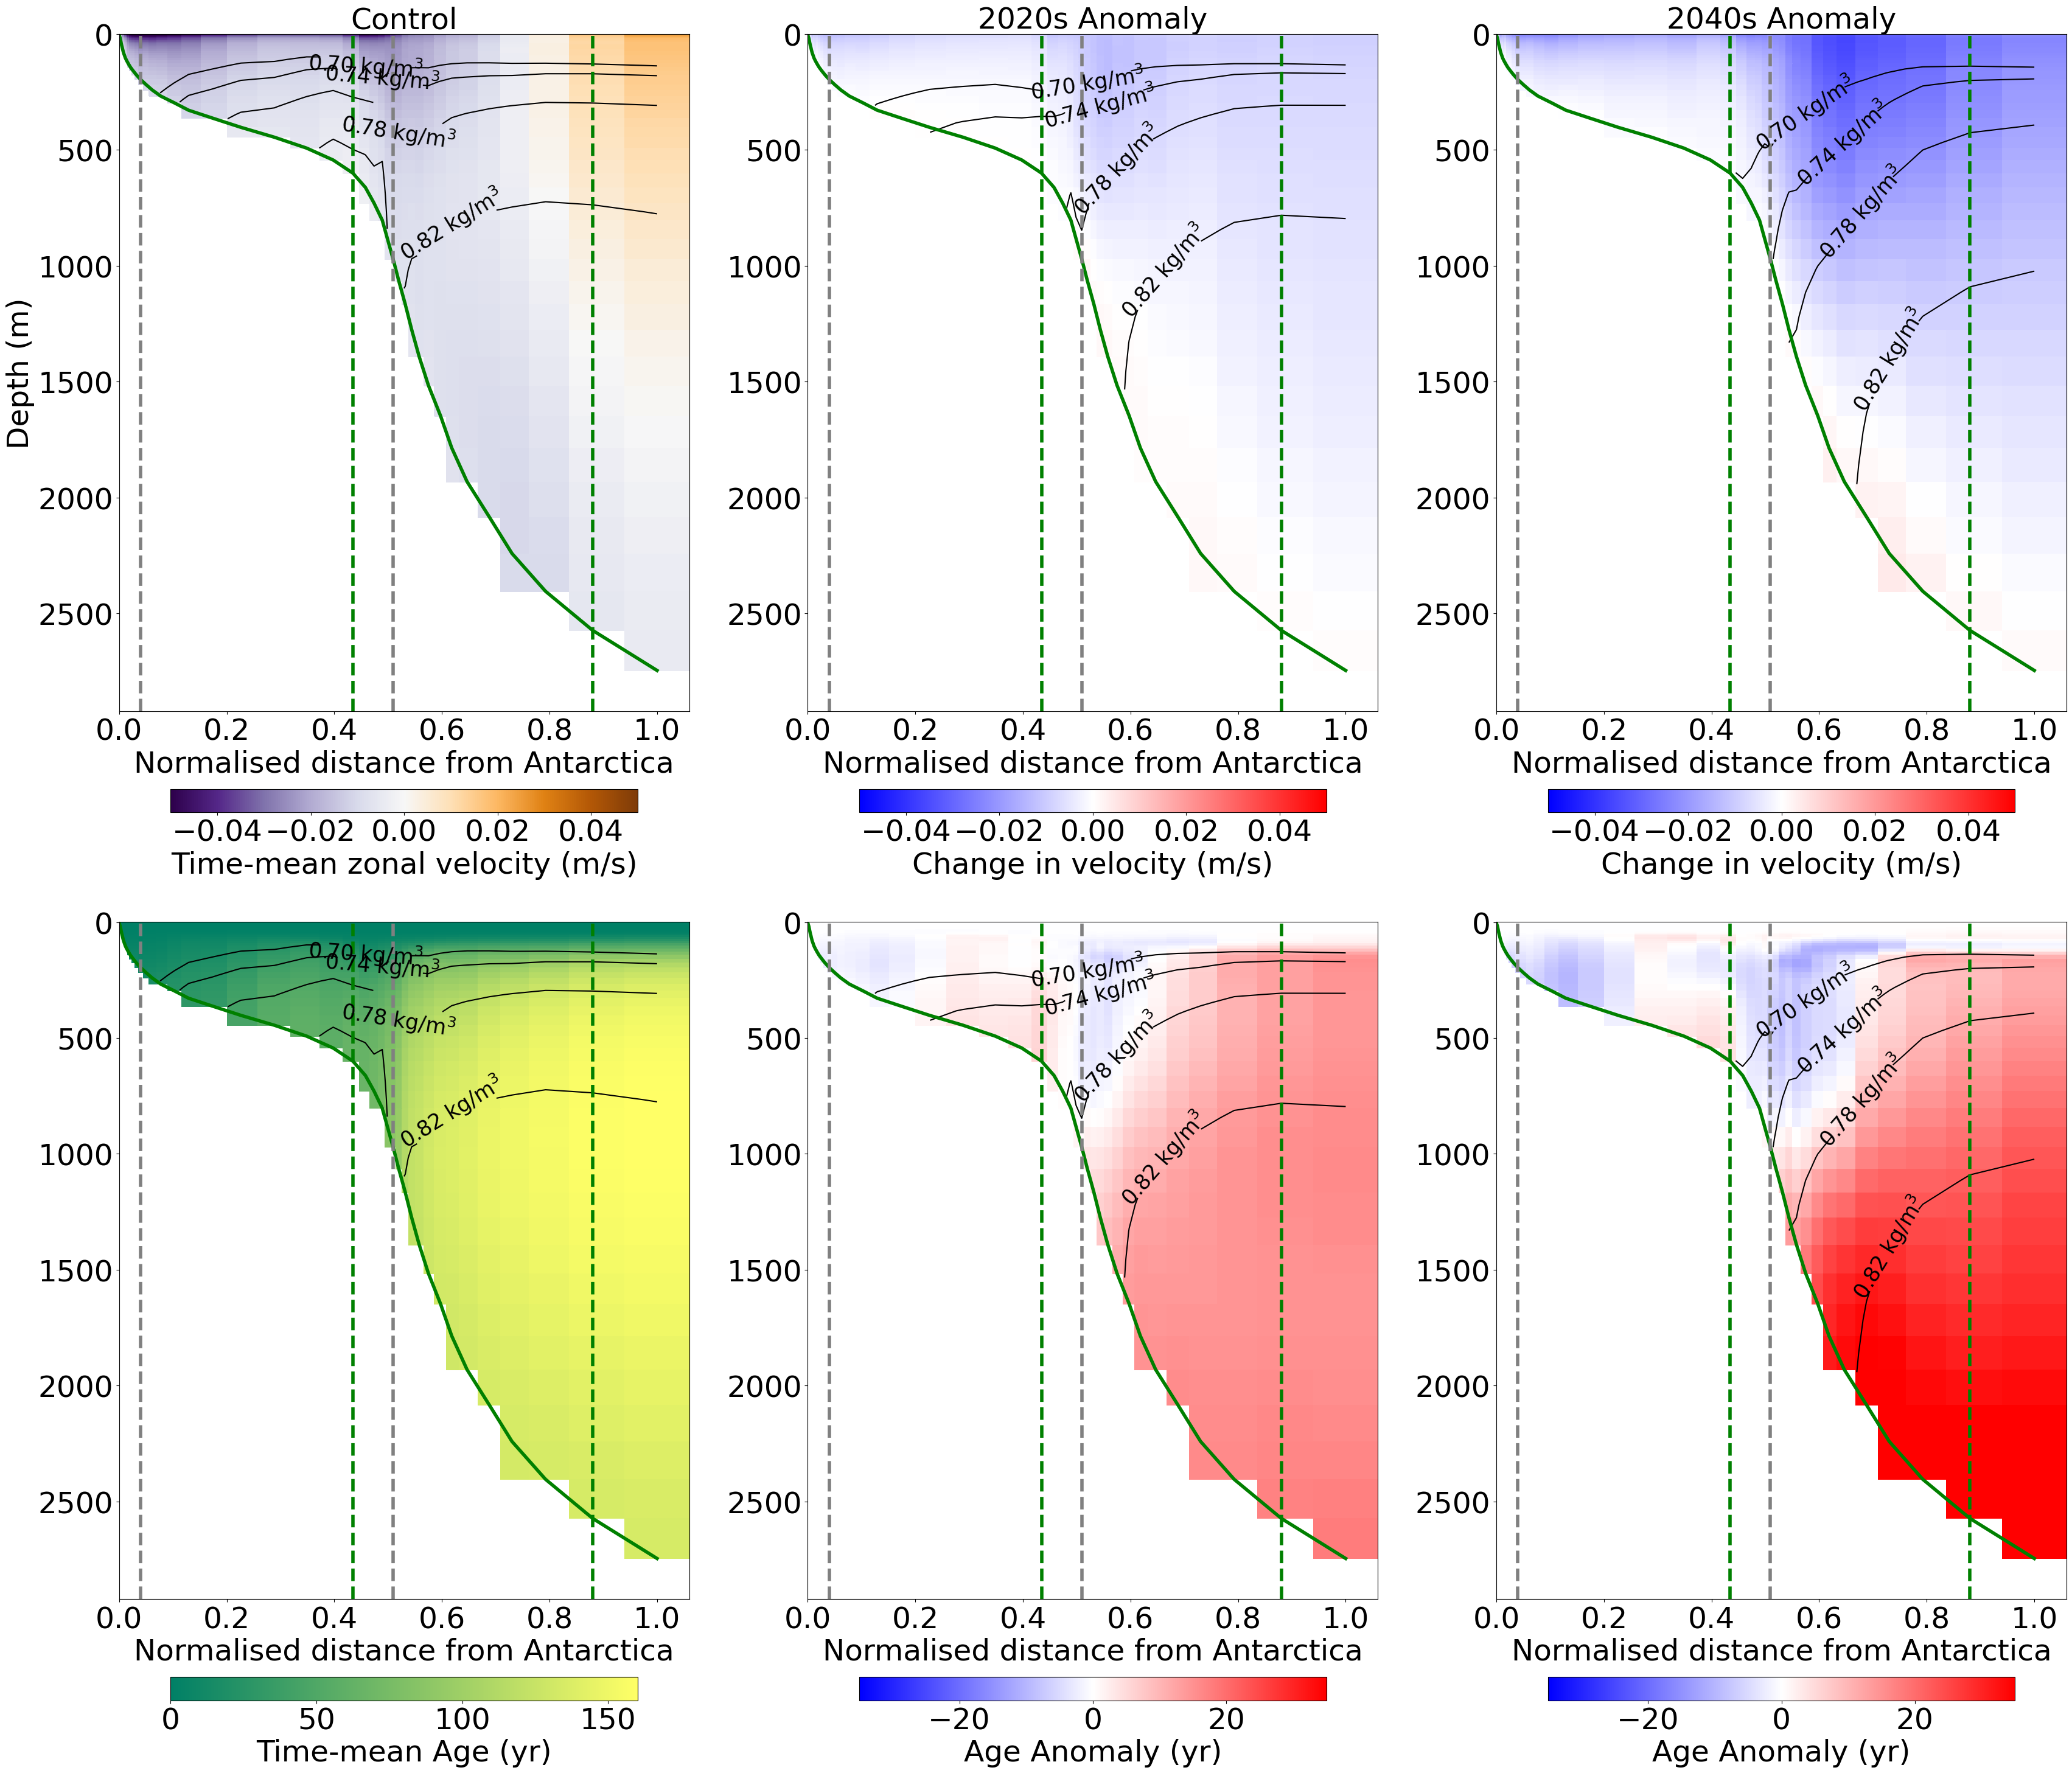

In [22]:
fig, axs = plt.subplots(ncols = 3,nrows = 2, figsize=(35,30), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.15, wspace=0.2)
#axs = axs.ravel()

im1 = axs[1,0].pcolor(normalised_area_cumsum, st_ocean, age_mean_ctrl_0.mean('time').histogram_ht.values , cmap=plt.cm.summer)
cb2 = plt.colorbar(im1, ax=axs[1,0], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Time-mean Age (yr)')

im2 = axs[1,1].pcolor(normalised_area_cumsum, st_ocean,(age_mean_30.mean('time').histogram_ht.values - age_mean_ctrl_0.mean('time').histogram_ht.values), \
                    vmin = -35, vmax = 35, cmap=plt.cm.bwr)
cb2 = plt.colorbar(im2, ax=axs[1,1], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Age Anomaly (yr)')

im3 = axs[1,2].pcolor(normalised_area_cumsum, st_ocean,(age_mean_50.mean('time').histogram_ht.values - age_mean_ctrl_0.mean('time').histogram_ht.values),  \
                    vmin = -35, vmax = 35, cmap=plt.cm.bwr)
cb2 = plt.colorbar(im3, ax=axs[1,2], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Age Anomaly (yr)')

vmin_rho = 0.7
vmax_rho = 0.9
vmin_u = -0.05
vmax_u = 0.05
fontsize = 25
lw = 5
levels_rho = np.linspace(vmin_rho, vmax_rho,6)
levels_u = np.linspace(vmin_u, vmax_u,11)


CS = axs[1,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = 'black')
kwargs = {'inline_spacing' : -30, 'inline': True, 'use_clabeltext' : True, 'fontsize':fontsize}#, 'fontweight':'bold'}
axs[1,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)
'''
CS = axs[0].contour(normalised_area_cumsum_u, st_ocean, u_mean_0.mean('time').histogram_hu.values, levels =levels_u,  vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr,lw = lw)
axs[0].clabel(CS, CS.levels, fmt= fmt, **kwargs)
'''
CS = axs[1,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho, colors = 'black')
axs[1,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)
'''
CS = axs[1].contour(normalised_area_cumsum_u, st_ocean, u_mean_30.mean('time').histogram_hu.values, levels =levels_u, vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr,lw = lw)
axs[1].clabel(CS, CS.levels, fmt =fmt, **kwargs)
'''
CS = axs[1,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = 'black')
axs[0,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)
'''
CS = axs[2].contour(normalised_area_cumsum_u, st_ocean, u_mean_50.mean('time').histogram_hu.values,levels =levels_u,  vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr,lw = lw)
axs[2].clabel(CS, CS.levels,  fmt =fmt, **kwargs)
'''
for i in range(3):
    axs[1,i].set_xlabel('Normalised distance from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[1,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[1,i])

    #axs[i].set_xlim([0,0.3])
axs[0,0].set_ylabel('Depth (m)')
axs[0,0].set_title('Control')
axs[0,1].set_title('2020s Anomaly')
axs[0,2].set_title('2040s Anomaly')

########## ZONAL VELOCITY

im1 = axs[0,0].pcolor(normalised_area_cumsum, st_ocean, u_mean_ctrl_0.mean('time').histogram_hu.values , vmin = vmin_u, vmax = vmax_u, cmap=plt.cm.PuOr_r)
cb2 = plt.colorbar(im1, ax=axs[0,0], fraction=0.03, pad=0.1,  orientation = 'horizontal')
cb2.set_label('Time-mean zonal velocity (m/s)')


im2 = axs[0,1].pcolor(normalised_area_cumsum, st_ocean, (u_mean_30.mean('time').histogram_hu.values - u_mean_0.mean('time').histogram_hu.values), \
                    vmin = vmin_u, vmax = vmax_u, cmap=plt.cm.bwr)
cb2 = plt.colorbar(im2, ax=axs[0,1], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Change in velocity (m/s)')

im3 = axs[0,2].pcolor(normalised_area_cumsum, st_ocean, (u_mean_50.mean('time').histogram_hu.values - u_mean_0.mean('time').histogram_hu.values),  \
                    vmin = vmin_u, vmax = vmax_u, cmap=plt.cm.bwr)
cb2 = plt.colorbar(im3, ax=axs[0,2], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Change in velocity (m/s)')

levels_rho = np.linspace(vmin_rho, vmax_rho,6)
levels_u = np.linspace(vmin_u, vmax_u,11)


CS = axs[0,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = 'black')
kwargs = {'inline_spacing' : -30, 'inline': True, 'use_clabeltext' : True, 'fontsize':fontsize}#, 'fontweight':'bold'}
axs[0,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)
'''
CS = axs[0].contour(normalised_area_cumsum_u, st_ocean, u_mean_0.mean('time').histogram_hu.values, levels =levels_u,  vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr,lw = lw)
axs[0].clabel(CS, CS.levels, fmt= fmt, **kwargs)
'''
CS = axs[0,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho, colors = 'black')
axs[0,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)
'''
CS = axs[1].contour(normalised_area_cumsum_u, st_ocean, u_mean_30.mean('time').histogram_hu.values, levels =levels_u, vmin=vmin_u, vmax=vmax_u, cmap=plt.cm.bwr,lw = lw)
axs[1].clabel(CS, CS.levels, fmt =fmt, **kwargs)
'''
CS = axs[0,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = 'black')
axs[0,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)
for i in range(3):
    axs[0,i].set_xlabel('Normalised distance from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[0,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[0,i])



plt.tight_layout()

[0.7  0.74 0.78 0.82 0.86 0.9 ]
[0.7  0.74 0.78 0.82 0.86 0.9 ]
[0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84 0.86 0.88 0.9 ]
[0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84 0.86 0.88 0.9 ]


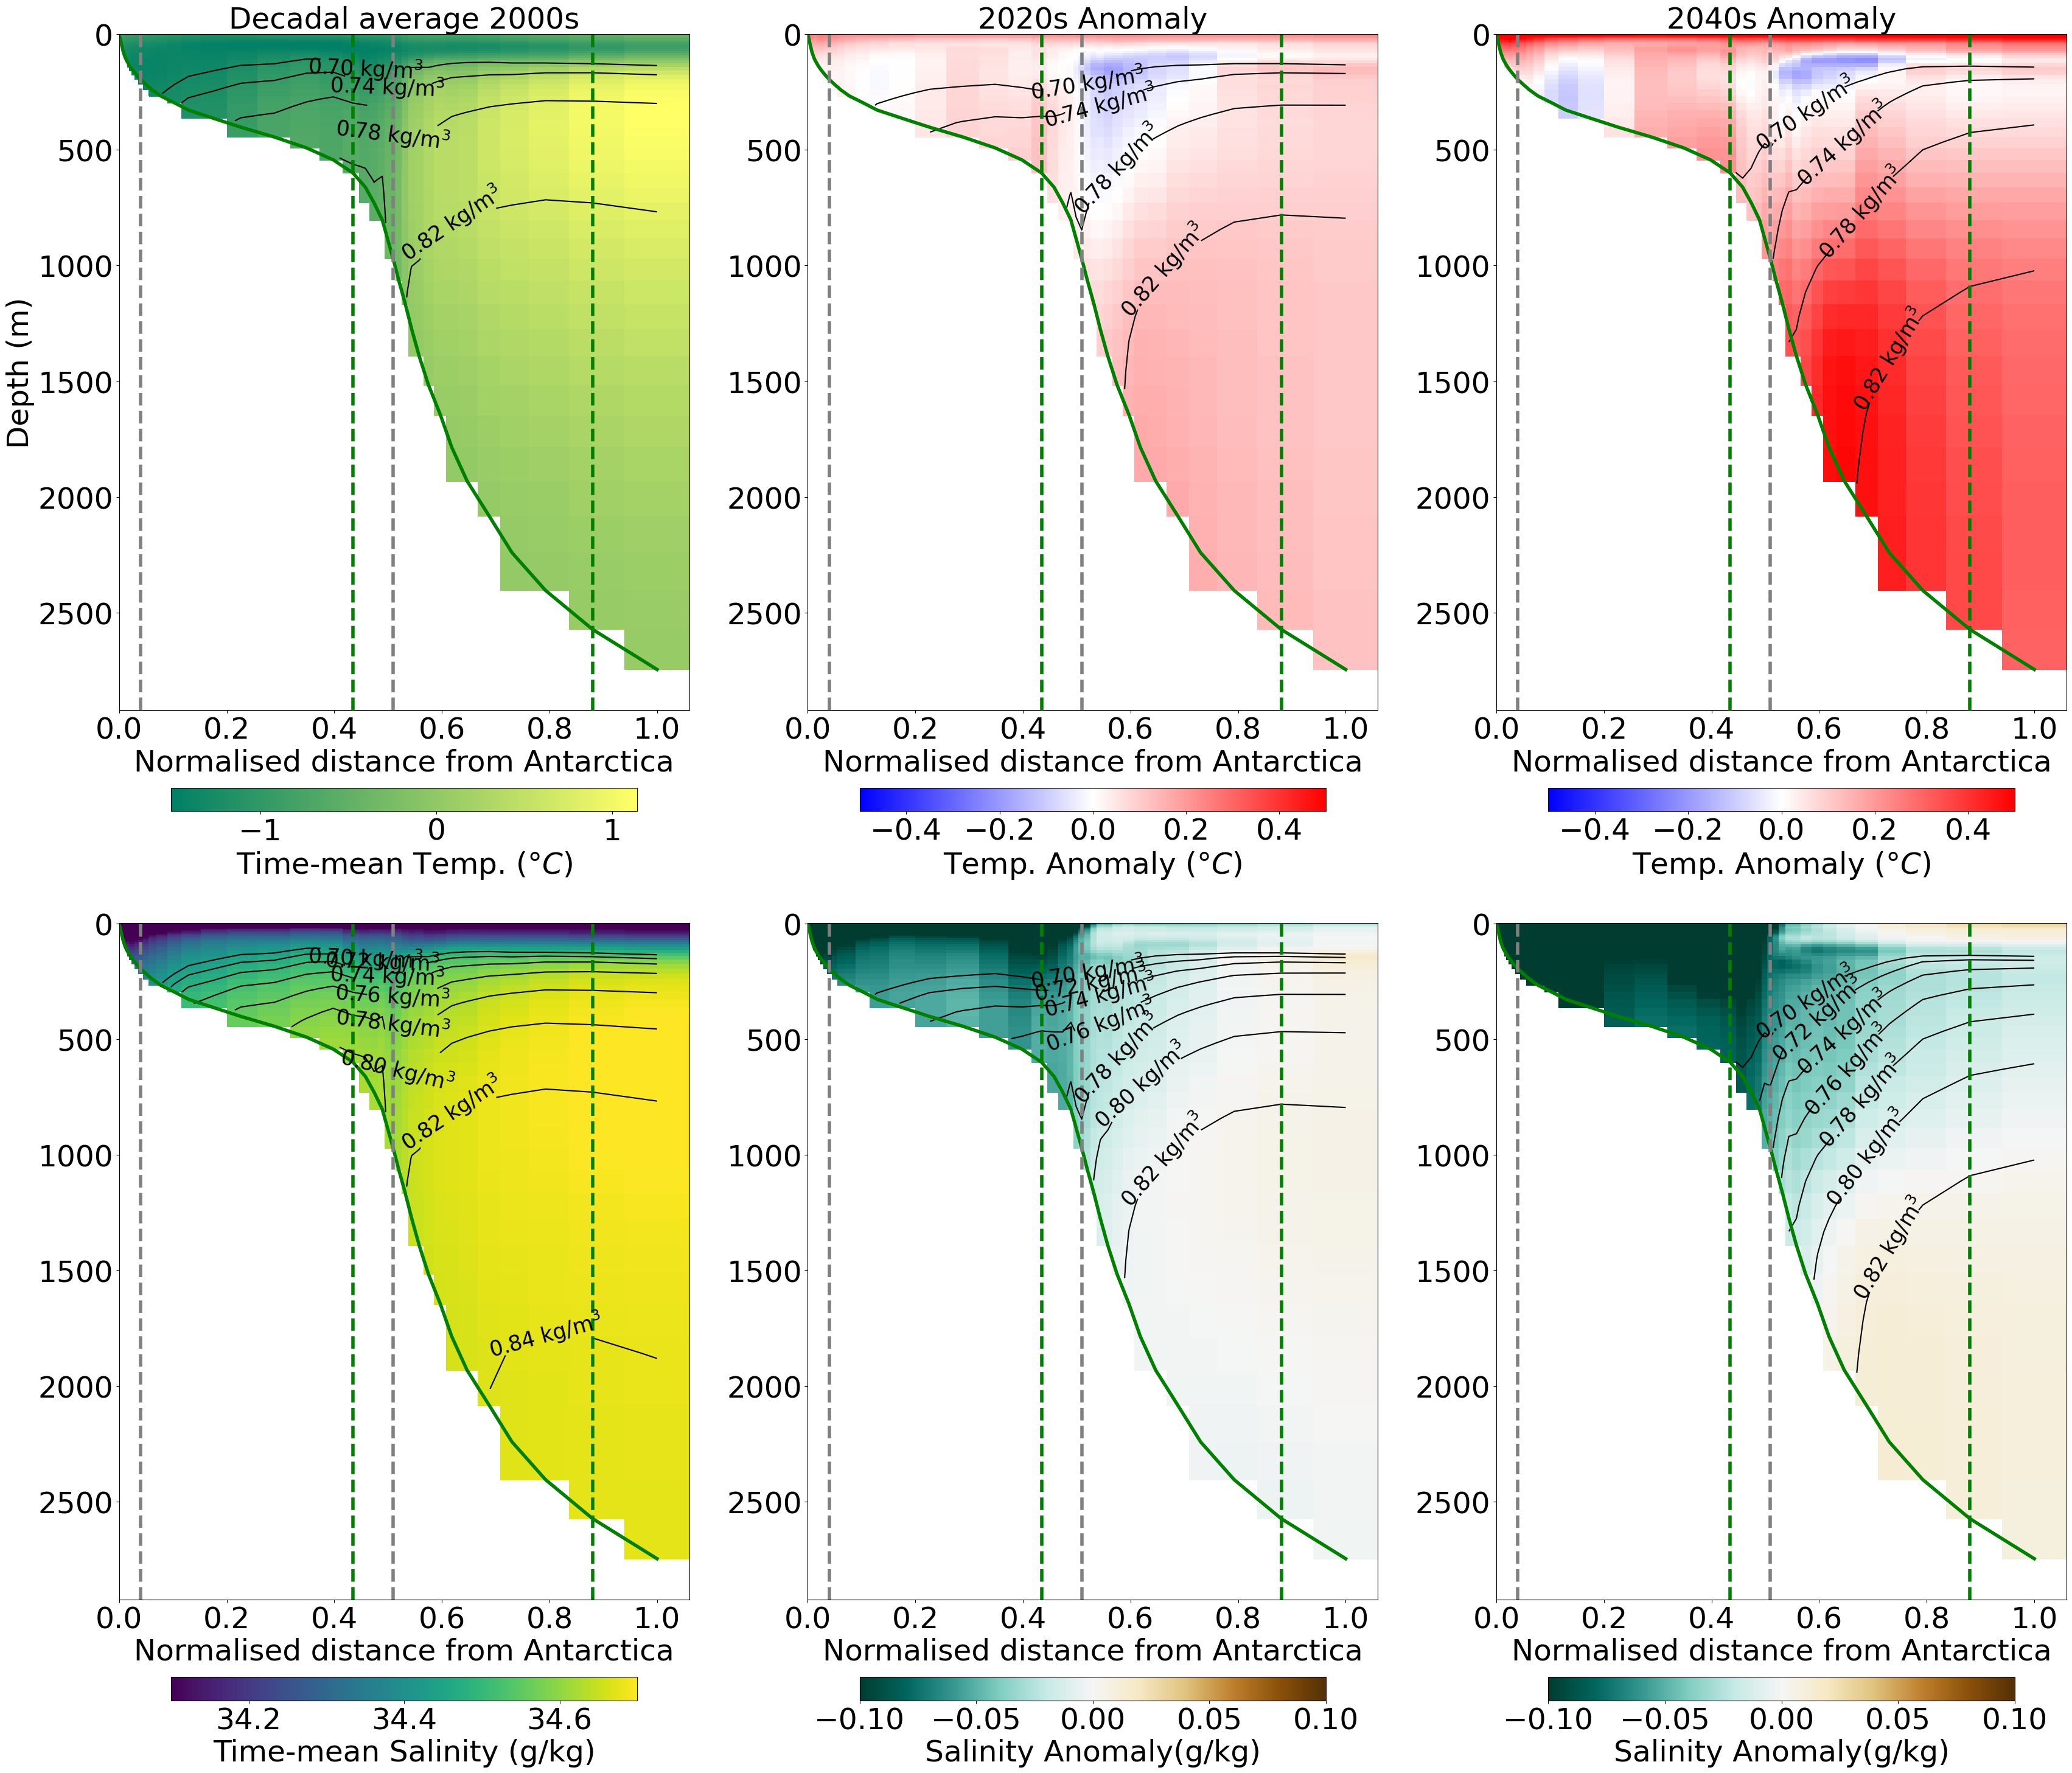

In [44]:
## SUPPLEMENTARY

fig, axs = plt.subplots(ncols = 3,nrows = 2, figsize=(35,30), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.15, wspace=0.2)
#axs = axs.ravel()

im1 = axs[0,0].pcolor(normalised_area_cumsum, st_ocean, T_mean_0.mean('time').histogram_ht.values -273 , cmap=plt.cm.summer)
cb2 = plt.colorbar(im1, ax=axs[0,0], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Time-mean Temp. ($\degree C$)')

im2 = axs[0,1].pcolor(normalised_area_cumsum, st_ocean,(T_mean_30.mean('time').histogram_ht.values - T_mean_0.mean('time').histogram_ht.values), \
                    vmin = -0.5, vmax = 0.5, cmap=plt.cm.bwr)
cb2 = plt.colorbar(im2, ax=axs[0,1], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Temp. Anomaly ($\degree C$)')

im3 = axs[0,2].pcolor(normalised_area_cumsum, st_ocean,(T_mean_50.mean('time').histogram_ht.values - T_mean_0.mean('time').histogram_ht.values),  \
                    vmin = -0.5, vmax = 0.5, cmap=plt.cm.bwr)
cb2 = plt.colorbar(im3, ax=axs[0,2], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Temp. Anomaly ($\degree C$)')
'''
vmin_rho = 0.7
vmax_rho = 1.0
vmin_u = -0.05
vmax_u = 0.05
fontsize = 25
lw = 5
levels_rho = np.linspace(vmin_rho, vmax_rho,11)
levels_u = np.linspace(vmin_u, vmax_u,11)
'''
# temp
CS = axs[0,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho,colors = 'black')
kwargs = {'inline_spacing' : -30, 'inline': True, 'use_clabeltext' : True, 'fontsize':fontsize}#, 'fontweight':'bold'}
axs[0,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[0,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho,colors = 'black')
axs[0,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

CS = axs[0,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = 'black')
axs[0,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

for i in range(3):
    axs[0,i].set_xlabel('Normalised distance from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[0,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[0,i])

    #axs[i].set_xlim([0,0.3])
axs[0,0].set_ylabel('Depth (m)')
axs[0,0].set_title('Decadal average 2000s')
axs[0,1].set_title('2020s Anomaly')
axs[0,2].set_title('2040s Anomaly')

########## salinty
im1 = axs[1,0].pcolor(normalised_area_cumsum, st_ocean, S_mean_0.mean('time').histogram_ht.values, vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
cb2 = plt.colorbar(im1, ax=axs[1,0], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Time-mean Salinity (g/kg)')


im2 = axs[1,1].pcolor(normalised_area_cumsum, st_ocean, S_mean_30.mean('time').histogram_ht.values - S_mean_0.mean('time').histogram_ht.values, vmin=-0.1, vmax = 0.1, cmap=plt.cm.BrBG_r)
cb2 = plt.colorbar(im2, ax=axs[1,1], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Salinity Anomaly(g/kg)')

im3 = axs[1,2].pcolor(normalised_area_cumsum, st_ocean, S_mean_50.mean('time').histogram_ht.values - S_mean_30.mean('time').histogram_ht.values, vmin=-0.1, vmax = 0.1, cmap=plt.cm.BrBG_r)
cb2 = plt.colorbar(im3, ax=axs[1,2], fraction=0.03, pad=0.1, orientation = 'horizontal')
cb2.set_label('Salinity Anomaly(g/kg)')

levels_rho = np.linspace(vmin_rho, vmax_rho,11)
levels_u = np.linspace(vmin_u, vmax_u,11)


CS = axs[1,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = 'black')
kwargs = {'inline_spacing' : -30, 'inline': True, 'use_clabeltext' : True, 'fontsize':fontsize}#, 'fontweight':'bold'}
axs[1,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[1,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho, colors = 'black')
axs[1,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

CS = axs[1,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = 'black')
axs[1,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)
for i in range(3):
    axs[1,i].set_xlabel('Normalised distance from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[1,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[1,i])



plt.tight_layout()

# houvmoller plot

In [11]:
expt

'01deg_jra55v13_ryf9091_qian_wthmp'

In [12]:
start_time='2110-01-01 00:00:00'
end_time='2159-12-31 00:00:00'


In [ ]:
Vu_sum.load()

In [ ]:
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)
u_mean_arr = []
for tt in range(600):#len(u.time)):
    u_sel = u.isel(time = tt)
    uV_sum = histogram(hu, bins = bins_isobath,\
                       dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u_sel)
    u_mean = uV_sum/Vu_sum
    u_mean.load()
    u_mean_arr.append(u_mean)

In [ ]:
u_houvmoller = xr.concat(u_mean_arr, dim = 'time')
u_houvmoller

In [83]:
u_houvmoller.to_netcdf('u_houvmoller_isobath.nc')

In [15]:
## load here
u_houvmoller = xr.open_mfdataset('u_houvmoller_isobath.nc')
u_houvmoller

<xarray.Dataset> Size: 27MB
Dimensions:       (hu_bin: 75, time: 600, st_ocean: 75)
Coordinates:
  * hu_bin        (hu_bin) float64 600B 0.5413 1.681 ... 5.511e+03 5.709e+03
Dimensions without coordinates: time, st_ocean
Data variables:
    histogram_hu  (time, st_ocean, hu_bin) float64 27MB dask.array<chunksize=(600, 75, 75), meta=np.ndarray>

In [16]:

isobath600m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 600).argmin(dim = 'hu_bin')
isobath750m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 750).argmin(dim = 'hu_bin')
isobath1000m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 1000).argmin(dim = 'hu_bin')
isobath1500m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 1500).argmin(dim = 'hu_bin')
isobath2000m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 2000).argmin(dim = 'hu_bin')
isobath2500m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 2500).argmin(dim = 'hu_bin')

isobath750m

<xarray.DataArray 'hu_bin' ()> Size: 8B
array(43)

In [17]:
u_houvmoller.hu_bin.isel(hu_bin= 46)

<xarray.DataArray 'hu_bin' ()> Size: 8B
array(1017.24370768)
Coordinates:
    hu_bin   float64 8B 1.017e+03
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       /g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [18]:
ACoC_umin_idx = u_houvmoller.isel(st_ocean = 0).argmin(dim = 'hu_bin').histogram_hu.T
ASC_umin_idx = u_houvmoller.isel(st_ocean = 0).isel(hu_bin = slice(43,75)).argmin(dim = 'hu_bin').histogram_hu.T + 43

In [19]:
abs_u = abs(u_houvmoller.isel(st_ocean = 0)).load()

In [20]:
sign_contour = abs_u.argmin(dim = 'hu_bin').histogram_hu.T

In [21]:
sign_contour_na = sign_contour.where(sign_contour<60)

In [22]:
sign_contour_na = sign_contour.where(sign_contour<60).dropna(dim = 'time')
sign_contour_na_val =[int(sign_contour_na[i])\
    for i in range(len(sign_contour_na.time))]


In [27]:
sign_contour_dist = normalised_area_cumsum[sign_contour_na_val]

In [28]:
ACoC_umin_dist = normalised_area_cumsum[ACoC_umin_idx]
ASC_umin_dist = normalised_area_cumsum[ASC_umin_idx]

In [29]:
sign_contour_time = sign_contour.time.where(sign_contour<60).dropna(dim = 'time')

In [30]:
normalised_area_cumsum[isobath750m.values].values * np.ones(600)

array([0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275603,
       0.12275603, 0.12275603, 0.12275603, 0.12275603, 0.12275

In [31]:

isobath300m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 300).argmin(dim = 'hu_bin')
isobath200m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 200).argmin(dim = 'hu_bin')


In [32]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25)

In [34]:
import cmocean

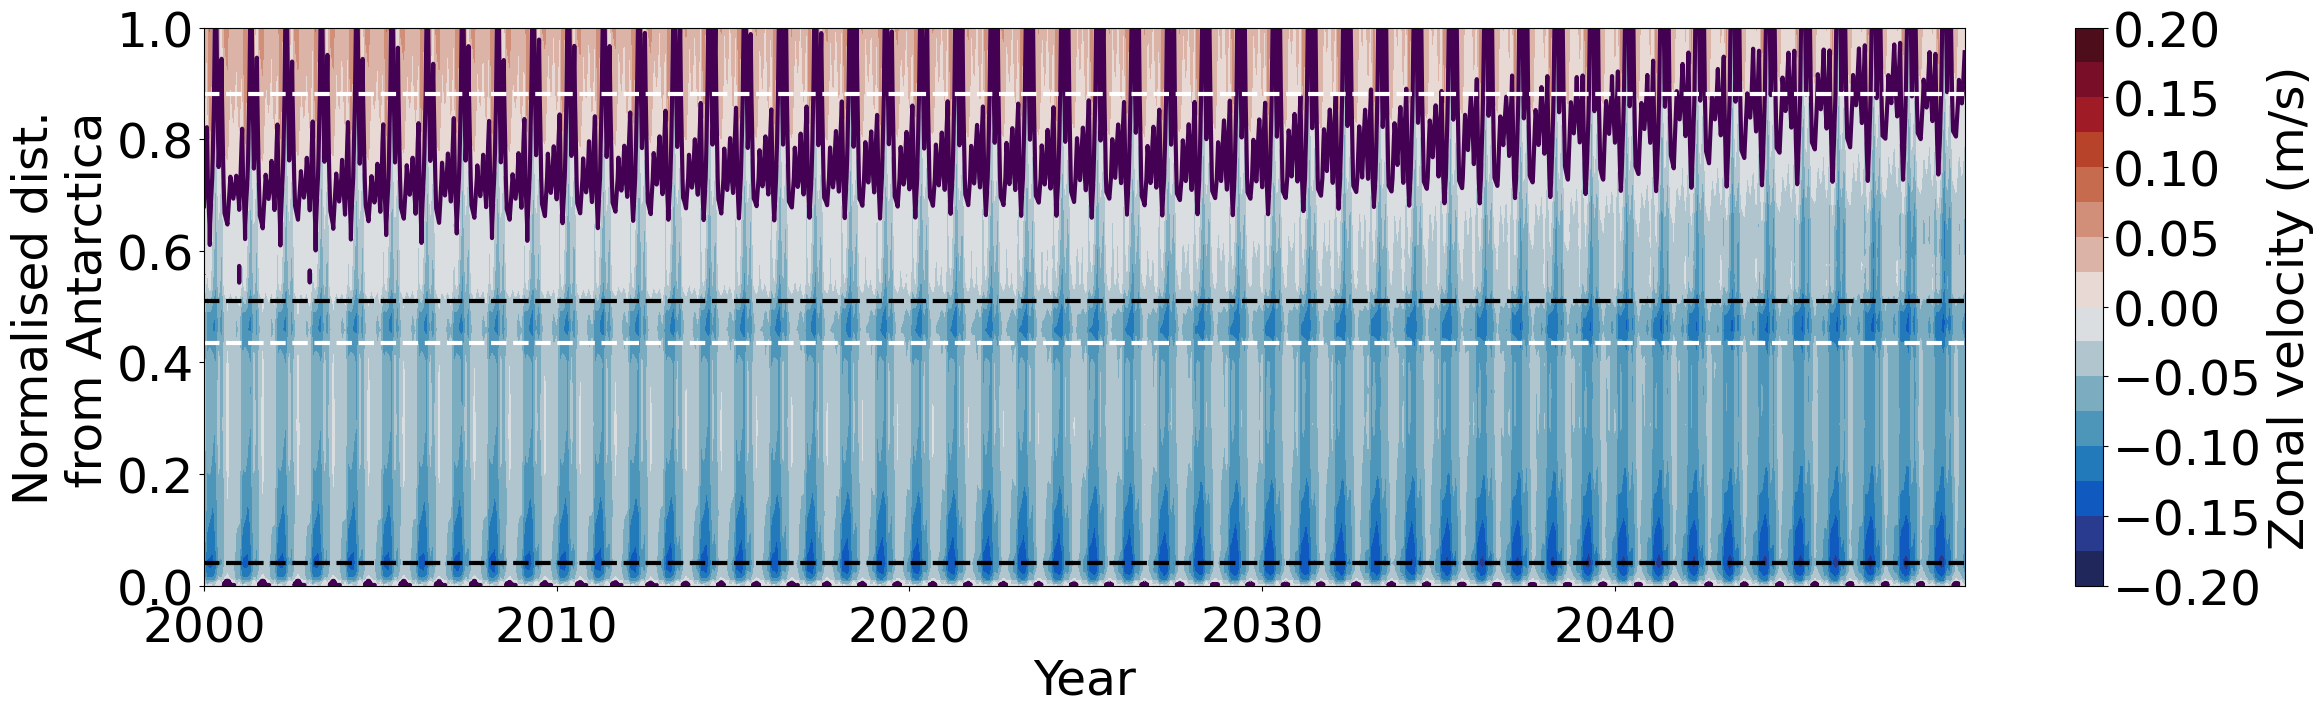

In [46]:
# FINAL HOUVMOLLER
fig, ax = plt.subplots( figsize = (25,8), sharex = True)
levels = np.arange(-0.2,0.225,0.025)
#plt.rcParams['xtick.major.pad']='8'
#plt.rcParams['ytick.major.pad']='8'

cmap = plt.contourf(u_houvmoller.time, normalised_area_cumsum,\
             u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
                    histogram_hu.T, levels = levels, cmap = cmocean.cm.balance)
plt.contour(u_houvmoller.time, normalised_area_cumsum,\
            u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
            histogram_hu.T, levels = [-0.0], c = 'k', linewidths  = 3)

plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath600m.values].values, \
         c = 'w', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath1000m.values].values, \
         c = 'k', lw  = 3, linestyle = 'dashed')

plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath2500m.values].values, \
         c = 'w', lw  = 3, linestyle = 'dashed')


plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath200m.values].values, \
         c = 'k', lw  = 3, linestyle = 'dashed')
#cmap = ax[1].imshow(u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).histogram_hu.T,  cmap = cmocean.balance)
plt.colorbar(cmap, orientation = 'vertical', label = 'Zonal velocity (m/s)')
ax.set_xticks(u_houvmoller.time[::120])
ax.set_xticklabels(np.arange(2000,2050, 10))
ax.xaxis.set_tick_params(pad=10)
ax.set_ylabel('Normalised dist.\n from Antarctica')
ax.set_xlabel('Year')

plt.tight_layout()

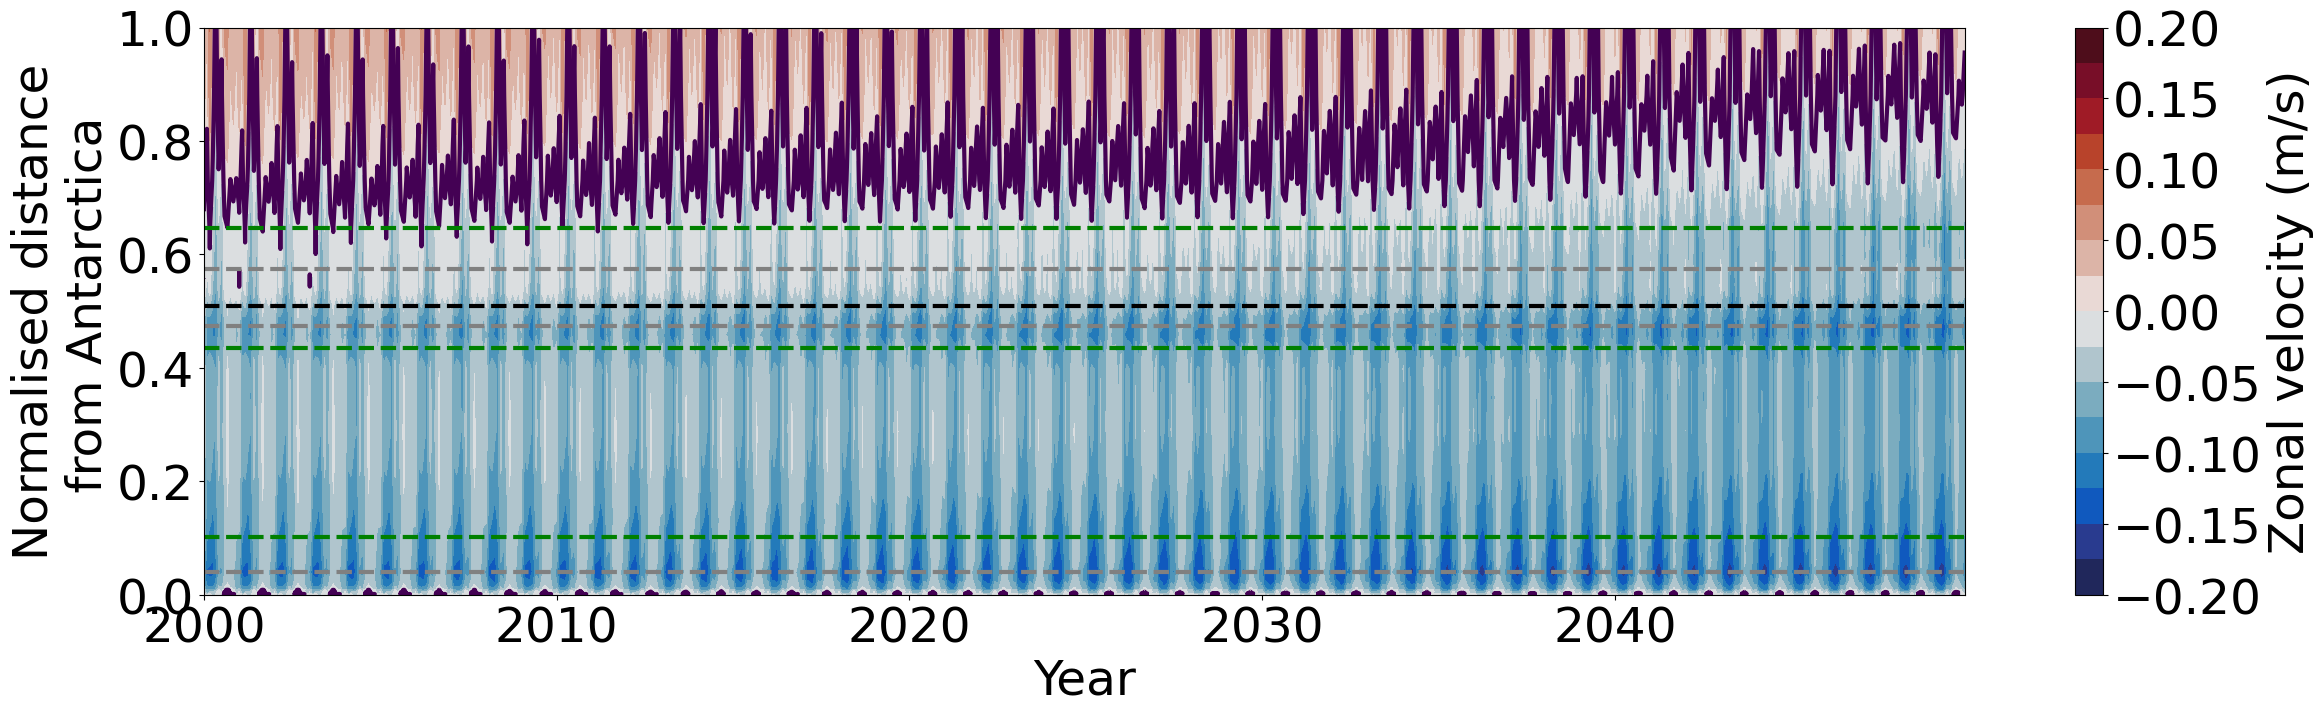

In [42]:
fig, ax = plt.subplots( figsize = (25,8), sharex = True)
levels = np.arange(-0.2,0.225,0.025)

cmap = plt.contourf(u_houvmoller.time, normalised_area_cumsum,\
             u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
                    histogram_hu.T, levels = levels, cmap = cmocean.balance)
plt.contour(u_houvmoller.time, normalised_area_cumsum,\
            u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
            histogram_hu.T, levels = [-0.0], c = 'k', linewidths  = 3)

#plt.plot(u_houvmoller.time, ASC_umin_dist,  c = 'k', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath600m.values].values, \
         c = 'g', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath750m.values].values, \
         c = 'gray', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath1000m.values].values, \
         c = 'k', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath1500m.values].values, \
         c = 'gray', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath2500m.values].values, \
         c = 'g', lw  = 3, linestyle = 'dashed')


plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath300m.values].values, \
         c = 'g', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath200m.values].values, \
         c = 'gray', lw  = 3, linestyle = 'dashed')
#cmap = ax[1].imshow(u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).histogram_hu.T,  cmap = cmocean.balance)
plt.colorbar(cmap, orientation = 'vertical', label = 'Zonal velocity (m/s)')
ax.set_xticks(u_houvmoller.time[::120])
ax.set_xticklabels(np.arange(2000,2050, 10))
ax.set_ylabel('Normalised distance\n from Antarctica')
ax.set_xlabel('Year')

plt.tight_layout()

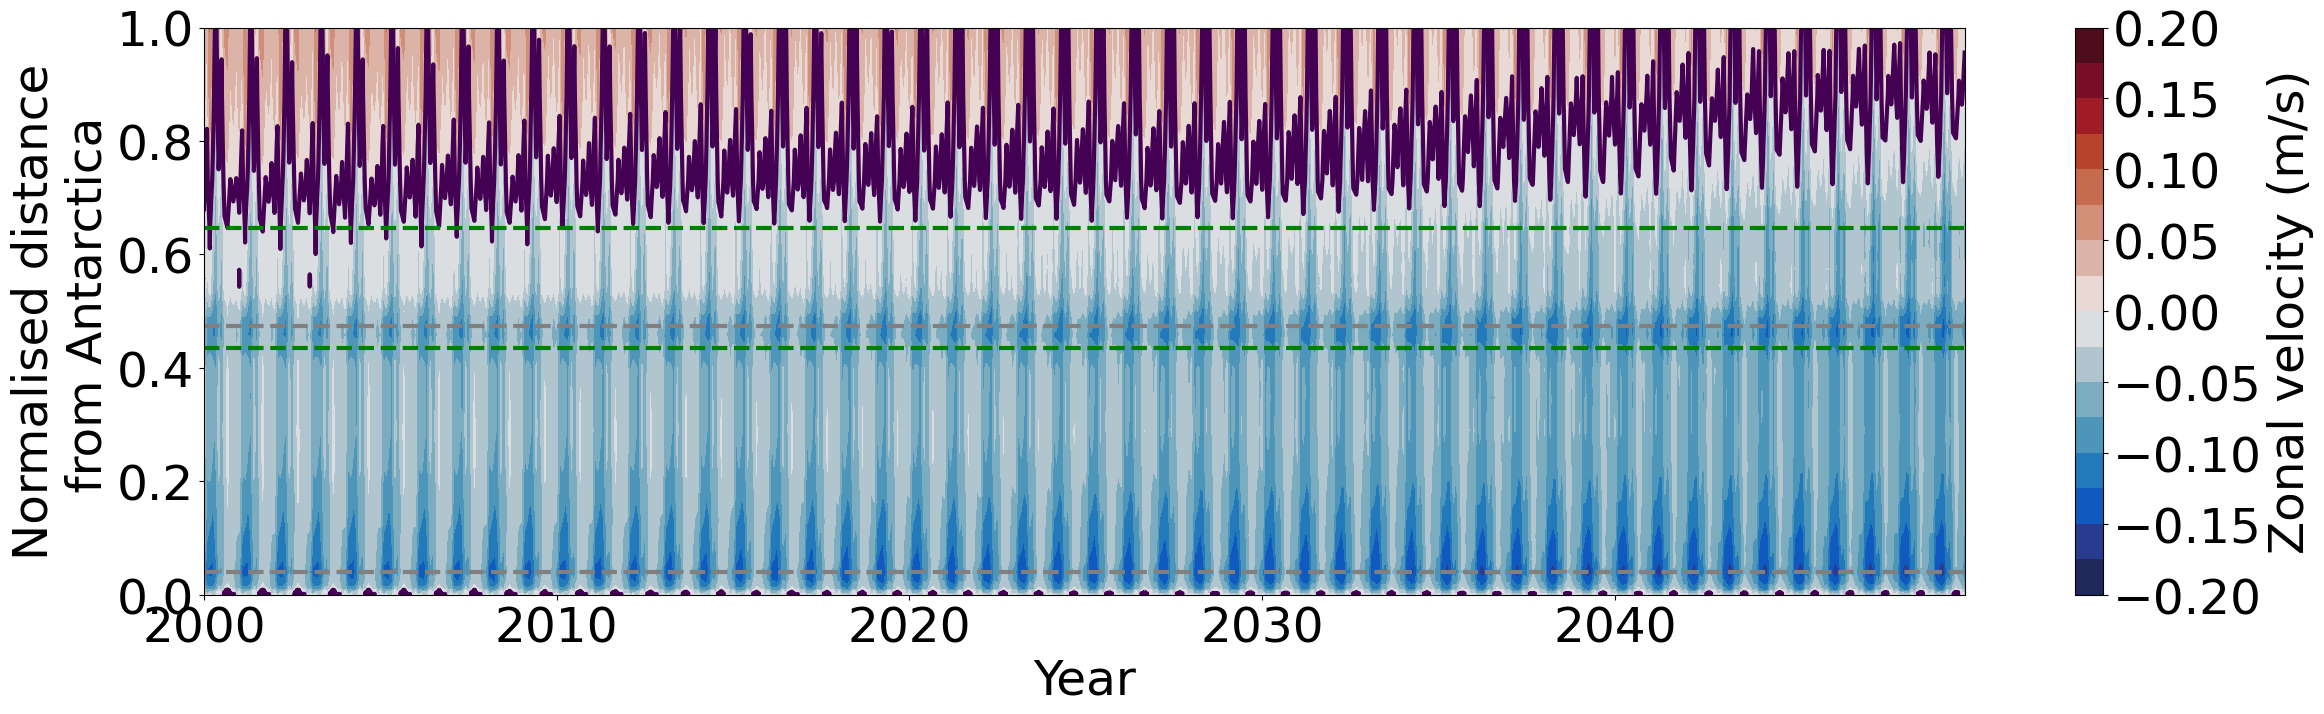

In [43]:
fig, ax = plt.subplots( figsize = (25,8), sharex = True)
levels = np.arange(-0.2,0.225,0.025)

cmap = plt.contourf(u_houvmoller.time, normalised_area_cumsum,\
             u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
                    histogram_hu.T, levels = levels, cmap = cmocean.balance)
plt.contour(u_houvmoller.time, normalised_area_cumsum,\
            u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
            histogram_hu.T, levels = [-0.0], c = 'k', linewidths  = 3)

#plt.plot(u_houvmoller.time, ASC_umin_dist,  c = 'k', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath600m.values].values, \
         c = 'g', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath750m.values].values, \
         c = 'gray', lw  = 3, linestyle = 'dashed')

plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath2000m.values].values, \
         c = 'g', lw  = 3, linestyle = 'dashed')

plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath200m.values].values, \
         c = 'gray', lw  = 3, linestyle = 'dashed')
#cmap = ax[1].imshow(u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).histogram_hu.T,  cmap = cmocean.balance)
plt.colorbar(cmap, orientation = 'vertical', label = 'Zonal velocity (m/s)')
ax.set_xticks(u_houvmoller.time[::120])
ax.set_xticklabels(np.arange(2000,2050, 10))
ax.set_ylabel('Normalised distance\n from Antarctica')
ax.set_xlabel('Year')

plt.tight_layout()